<b><u><h1>Data Science final project - Fake & Real images recognition</h1></u>
by Lior Guetta & Roi Levi

<h1><b>TOC</h1>

1. [Introduction](#intro)
    * [Data gathering](#DG)
    * [Methods](#MET)
2. [EDA (Exploratory Data Analysis)](#EDA)
    * [Basic analysis](#EDA)
    * [Factor loading](#FL)
3. [Basic clustering using K-mean](#BC)
4. [Feature Extraction](#FE)
5. [HOG's (Histogram of Oriented Gradients)](#HOG)
    - [Dimension redusion & Clustering](#DR)
    - [Logistic regression](#LR)  
6. [CNN (Convolutional Neural Network)](#CNN)
    * [basic network model](#bnm)
    * [ResNet-50 model](#resnet)
7. [Models comparison](#MC)
8. [Research conclusion](#REC)

Bonus: Frequency domain

<a class="anchor" id="intro"></a>

<h1><b>Introduction</b></h1>

In today's world, where technology is always moving forward, we've reached a point where it's hard to tell if a picture is real or made by a computer. Artificial intelligence (AI) has become so good at making images that look like real photos, it's becoming a challenge to tell them apart. This project focuses on figuring out which images are real and which are made by AI.

As more and more images made by AI show up everywhere, we face new problems. Sometimes, these images might be changed or completely made up, and it's really important to find ways to tell if an image is real or not. Our project wants to solve this problem by finding methods that can clearly show if a picture was made by a computer or if it's a real photo.

<b>Here are just a few examples of image generators that we are encountering:</b>

<img src="https://www.educatorstechnology.com/wp-content/webp-express/webp-images/uploads/2023/03/1-21.png.webp" alt="image generator applications" width="400"/>

<b><u>Our purposal</u></b>

We're going to look closely at how to analyze images, use collections of both real and AI-made pictures, and apply some smart computing techniques. Our goal is to help people understand more about how trustworthy digital pictures are.

We're starting this project to separate real pictures from those made by AI, and we invite you to join us in this exciting challenge. By working on this, we hope to help make a future where we can look at a digital picture and know if it's real, making our digital world a more trustworthy place.

<hr>

requirements

In [ ]:
%pip install opendatasets
%pip install pandas
%pip install seaborn
%pip install matplotlib.pyplot
%pip install tensorflow
%pip install numpy

imports

In [1]:
import opendatasets as od
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import shutil
import random
import numpy as np
from PIL import Image
import seaborn as sns


<hr>

<a class="anchor" id="DG"></a>

<h2><b>Data gathering</b></h2>


The dataset we will be utilizing is CIFAKE, which comprises 60,000 synthetically generated images and 60,000 authentic images sourced from CIFAR-10. CIFAR-10 is a widely employed collection of images for training machine learning and computer vision algorithms. It encompasses pictures of airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks, making it one of the most prevalent datasets in machine learning research. The dataset is categorized into two classes: <b>REAL and FAKE</b>.

For the REAL class, the images were collected from Krizhevsky & Hinton's CIFAR-10 (Canadian Institute For Advanced Research) dataset.

Concerning the FAKE images, they were generated using Stable Diffusion version 1.4, a technique primarily employed for generating detailed images conditioned on text descriptions. While its main application is generating images guided by text, Stable Diffusion can also be applied to other tasks such as inpainting, outpainting, and image-to-image translations based on a text prompt. In this dataset, fake photos are generated by providing Stable Diffusion with real photos from CIFAR-10, and Stable Diffusion, in turn, generates synthetic photos.

<a href="https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images">click here</a> to see the source.

<b>download the data set</b>

In [ ]:
od.download("https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading cifake-real-and-ai-generated-synthetic-images.zip to .\cifake-real-and-ai-generated-synthetic-images


100%|██████████| 105M/105M [00:44<00:00, 2.44MB/s] 


<b>here we can see some data in every class</b>

In [ ]:
# reading the XLSX file
fake_folder =('cifake-real-and-ai-generated-synthetic-images\\train\FAKE')

images_path = []
for filename in os.listdir(fake_folder):
  img = os.path.join(fake_folder,filename)
  if img is not None:
      images_path.append(img)

# reading the XLSX file
real_folder =('cifake-real-and-ai-generated-synthetic-images\\train\REAL')

r_images_path = []
for r_filename in os.listdir(real_folder):
  r_img = os.path.join(real_folder,r_filename)
  if img is not None:
      r_images_path.append(r_img)

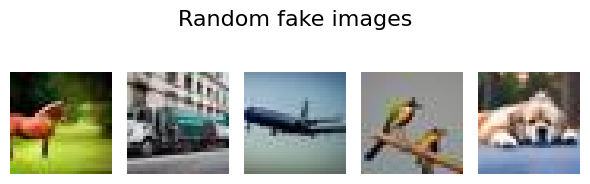

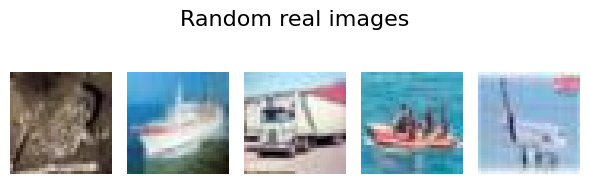

In [ ]:
import random
import cv2
import matplotlib.pyplot as plt

# Create a figure with 5 subplots side by side
fig, axes = plt.subplots(1, 5, figsize=(6, 2))
fig.suptitle("Random fake images", fontsize=16)

# Loop to display 5 random FAKE images
for i in range(5):
    j = random.randint(0, 39999)
    image = cv2.imread(images_path[j])

    # Check if the image was loaded successfully
    if image is not None:
        # Displaying the image in the corresponding subplot
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    else:
        print(f"Error loading image {images_path[j]}")

# Remove axis labels and ticks
for ax in axes:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

#
# Create a figure with 5 subplots side by side
fig, axes = plt.subplots(1, 5, figsize=(6, 2))
fig.suptitle("Random real images", fontsize=16)

# Loop to display 5 random REAL images
for i in range(5):
    j = random.randint(0, 39999)
    image = cv2.imread(r_images_path[j])

    # Check if the image was loaded successfully
    if image is not None:
        # Displaying the image in the corresponding subplot
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    else:
        print(f"Error loading image {r_images_path[j]}")

# Remove axis labels and ticks
for ax in axes:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()


<b>While examining these random images, it becomes apparent that distinguishing differences is not as straightforward for our eyes.</b>

<a class="anchor" id="MET"></a>

<h2><b>Methods</b></h2>

In our exploration of image classification methods to distinguish between real and fake images, we employ a range of techniques.
We begin with the <b>Basic Clustering</b> method, which utilizes fundamental clustering techniques to identify patterns and form the basis for classification.

Later in our analysis, we will leverage feature extraction using the <b>ViT model</b>, applying three distinct classification methods to these features: <b>Logistic Regression</b>, <b>Support Vector Machine (SVM)</b>, and <b>Random Forest</b>. A detailed discussion on these approaches will follow.

Continuing our exploration, we shift our focus to <b>HOG's (Histogram of Oriented Gradients)</b>, our examination encompasses different dimension reduction techniques, including mean values, PCA, and the incorporation of non-linear t-Distributed Stochastic Neighbor Embedding (t-SNE). This multifaceted approach allows us to observe the impact of dimensionality reduction on 2D and 3D representations, providing a comprehensive understanding of the interplay between these techniques in enhancing feature extraction and discrimination capabilities.

Next, we will turn our focus to applying <b>Logistic Regression</b> to the HOG data we explored and used before.

Furthering our journey, we explore the <b>Basic CNN Model</b>, employing a Convolutional Neural Network for automatic learning and differentiation of image features.

Finally, the <b>ResNet-50 Model</b> takes a deeper dive by using a deep residual network, extracting hierarchical features for nuanced discrimination. Each method brings its unique strengths to the table, collectively contributing to a comprehensive and sophisticated approach to image classification.

<hr>

<a class="anchor" id="EDA"></a>

<h1><b>EDA (Exploratory Data Analysis)</b></h1>

In our quest to distinguish authentic images from AI-generated ones, Exploratory Data Analysis (EDA) plays a pivotal role.
EDA is our compass through the sea of data, guiding us to uncover critical insights about image characteristics.
Our primary focus during this analysis will revolve around five key aspects: the number of colors, sharpness, brightness, contrast and edge detection.

<b>1. Number of Colors:</b>

We begin our analysis by exploring the color diversity within each image. The number of colors used in an image can offer clues about its origin, as AI-generated images might display color usage patterns distinct from those captured by cameras.

for example in this image the number of colors is 2:

<img src="https://www.shutterstock.com/shutterstock/photos/1729182961/display_1500/stock-vector-seamless-abstract-greek-key-background-pattern-1729182961.jpg" alt="2 color image" width="100"/>

<b>2. Sharpness:</b>

The sharpness of an image often holds the key to its authenticity. We will analyze the sharpness levels to discern if there's a noticeable difference between AI-generated and real images, with a focus on edge definition and clarity.

<b>3. Contrast:</b>

Contrast, the range of difference between the darkest and lightest parts of an image, can be telling. Our analysis will seek to understand if AI-generated images exhibit contrast patterns that set them apart from those taken by conventional cameras.

<b>4. Brightness:</b>

The overall brightness of an image is another attribute we will scrutinize. We aim to investigate whether the brightness levels in AI-generated images have distinct characteristics compared to real images.


<b>5. Edge Detection:</b>

Edge detection is a process of identifying sharp intensity transitions or boundaries in an image. It is crucial for detecting important features like object boundaries. The Canny edge detector is a popular algorithm for edge detection.

1. <b>Number of edges:</b>
The number of edges in an image, quantifying transitions between regions, is a fundamental metric for assessing visual complexity and aiding tasks like object recognition through algorithms such as Canny edge detection.


2. <b>Average edge length: </b>
Average edge length,denotes the mean length of detected edges. Calculated by dividing the total length of edges by the number of edges, it offers insights into the typical scale and size of the edges present in an image, aiding in the characterization of structural details and the overall visual content.



* In our dedicated exploratory data analysis (EDA), we seek nuanced insights into the intricacies of these specific image attributes. This exploration serves as a compass, guiding us towards well-informed choices in data preprocessing, feature selection, and subsequent model development. The narrative we construct around these facets of image analysis is pivotal, laying the foundation for a resilient system adept at distinguishing between authentic and AI-generated images.

Concluding this chapter, we pivot towards investigating the relationship between the two classes through the lens of factor loadings.

In [2]:
# path to the directories:
base_path = './cifake-real-and-ai-generated-synthetic-images'
TEST, TRAIN = 'test', 'train'
REAL, FAKE = 'REAL', 'FAKE'
test_fake = os.listdir('./cifake-real-and-ai-generated-synthetic-images/test/FAKE')
test_real = os.listdir('./cifake-real-and-ai-generated-synthetic-images/test/REAL')
train_fake = os.listdir('./cifake-real-and-ai-generated-synthetic-images/train/FAKE')
train_real = os.listdir('./cifake-real-and-ai-generated-synthetic-images/train/REAL')

In [3]:
# some variables..
arr_fake = []
arr_real = []
arr_fake_num_colors = []
arr_real_num_colors = []
arr_fake_sharpness = []
arr_real_sharpness = []
arr_fake_brightness = []
arr_real_brightness = []
arr_fake_contrast = []
arr_real_contrast = []
arr_fake_num_of_edges = []
arr_real_num_of_edges = []
arr_fake_edge_density = []
arr_real_edge_density = []
arr_fake_avg_edge_length = []
arr_real_avg_edge_length = []
max_colors = 10000
total_colors_fake = 0
total_colors_real = 0
total_sharpness_fake = 0
total_sharpness_real = 0
total_brightness_fake = 0
total_brightness_real = 0
total_contrast_fake = 0
total_contrast_real = 0
total_num_edges_real = 0
total_avg_edge_length_real = 0
total_num_edges_fake = 0
total_avg_edge_length_fake = 0

<b>Fake images loop</b>

In [4]:
fake_images_attr_vector = []

for picture in train_fake :
    # read & open image
    image = cv2.imread(os.path.join(base_path, TRAIN, FAKE, picture))
    img = Image.open(os.path.join(base_path, TRAIN, FAKE, picture))

    # convert to gray scale image.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 1. number of colors
    number_of_colors = len(img.getcolors(max_colors))
    total_colors_fake = total_colors_fake + number_of_colors
    arr_fake_num_colors.append(len(img.getcolors(max_colors)))
    # 2. sharpeness
    sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
    total_sharpness_fake = total_sharpness_fake + sharpness
    arr_fake_sharpness.append(sharpness)
    # 3. brightness
    brightness = int(gray.mean())
    total_brightness_fake = total_brightness_fake+brightness
    arr_fake_brightness.append(brightness)
    # 4. contarst
    contrast = np.std(gray)
    total_contrast_fake = total_contrast_fake +contrast
    arr_fake_contrast.append(contrast)
    #5 edge
    # Apply Gaussian blur to the image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    num_edges = np.sum(edges > 0)
    total_num_edges_fake = total_num_edges_fake +num_edges
    arr_fake_num_of_edges.append(num_edges)
    average_edge_length = np.sum(edges) / num_edges if num_edges > 0 else 0
    total_avg_edge_length_fake = total_avg_edge_length_fake + average_edge_length
    arr_fake_avg_edge_length.append(average_edge_length)

    arr_fake.append(image)
    fake_images_attr_vector.append([number_of_colors, sharpness, brightness,contrast])

<b>Real images loop</b>

In [5]:
real_images_attr_vector = []

for picture in train_real :
    # read & open image
    image = cv2.imread(os.path.join(base_path, TRAIN, REAL, picture))
    img = Image.open(os.path.join(base_path, TRAIN, REAL, picture))

     # convert to gray scale image.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 1. number of colors
    number_of_colors = len(img.getcolors(max_colors))
    total_colors_real = total_colors_real + number_of_colors
    arr_real_num_colors.append(len(img.getcolors(max_colors)))
    # 2. sharpeness
    sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
    total_sharpness_real = total_sharpness_real + sharpness
    arr_real_sharpness.append(sharpness)
    # 3. brightness
    brightness = int(gray.mean())
    total_brightness_real = total_brightness_real+brightness
    arr_real_brightness.append(brightness)
    # 4. contarst
    contrast = np.std(gray)
    total_contrast_real = total_contrast_real + contrast
    arr_real_contrast.append(contrast)
    #5 edge
    # Apply Gaussian blur to the image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    num_edges = np.sum(edges > 0)
    total_num_edges_real = total_num_edges_real +num_edges
    arr_real_num_of_edges.append(num_edges)
    average_edge_length = np.sum(edges) / num_edges if num_edges > 0 else 0
    total_avg_edge_length_real = total_avg_edge_length_real + average_edge_length
    arr_real_avg_edge_length.append(average_edge_length)

    arr_real.append(image)
    real_images_attr_vector.append([number_of_colors, sharpness, brightness,contrast])

<b>We can see now the distribution in every category we explain before.</b>

<b>1. number of colors:</b>

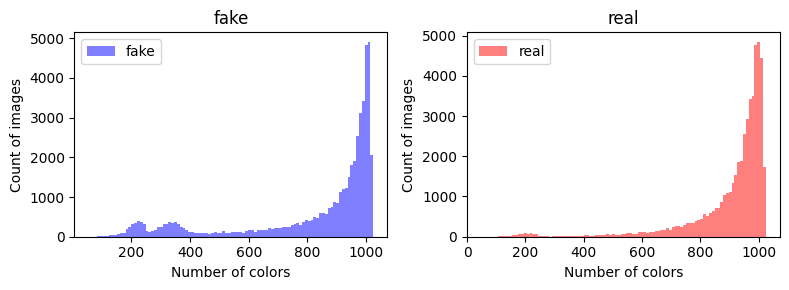

Average number of colors for fake images:  826.076
Average number of colors for real images:  907.034


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # 1 row, 2 columns
# Plot histogram for dataset 1 in the first subplot
axes[0].hist(arr_fake_num_colors, bins=100, alpha=0.5, color='blue', label='fake')
axes[0].set_xlabel('Number of colors')
axes[0].set_ylabel('Count of images')
axes[0].set_title('fake')
axes[0].legend()

# Plot histogram for dataset 2 in the second subplot
axes[1].hist(arr_real_num_colors, bins=100, alpha=0.5, color='red', label='real')
axes[1].set_xlabel('Number of colors')
axes[1].set_ylabel('Count of images')
axes[1].set_title('real')
axes[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
print('Average number of colors for fake images: ',round((total_colors_fake/len(train_fake)),3))
print('Average number of colors for real images: ',round((total_colors_real/len(train_real)),3))

We can derive from these graphical representations that fake images exhibit a reduced color spectrum. Notably, we discern three prominent peaks in the values at 200, 350, and 1000 within the fake images, whereas in the case of real images, these peaks are predominantly confined to the 1000 values.

This insight holds the potential to assist us in future endeavors.

<b>2. Sharpness:</b>

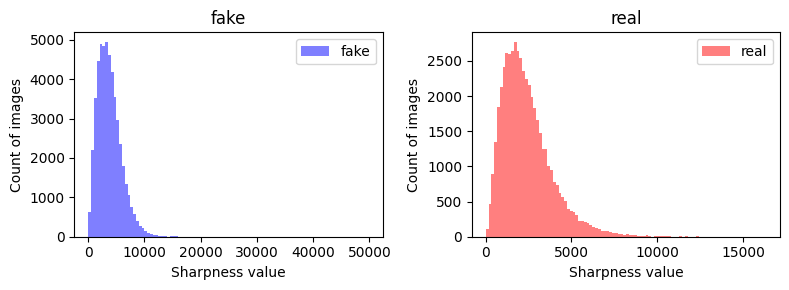

Average sharpness for fake images:  3772.899
Average sharpness for real images:  2432.842


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
# Plot histogram for dataset 1 in the first subplot
axes[0].hist(arr_fake_sharpness, bins=100, alpha=0.5, color='blue', label='fake')
axes[0].set_xlabel('Sharpness value')
axes[0].set_ylabel('Count of images')
axes[0].set_title('fake')
axes[0].legend()

# Plot histogram for dataset 2 in the second subplot
axes[1].hist(arr_real_sharpness, bins=100, alpha=0.5, color='red', label='real')

axes[1].set_xlabel('Sharpness value')
axes[1].set_ylabel('Count of images')
axes[1].set_title('real')
axes[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

print('Average sharpness for fake images: ',round((total_sharpness_fake/len(train_fake)),3))
print('Average sharpness for real images: ',round((total_sharpness_real/len(train_real)),3))

An intriguing deduction arising from our graphical representations is the unexpected observation that, on average, fake images manifest a significantly higher degree of sharpness, surpassing real images by a remarkable 50%. This rather surprising revelation bears the potential to assume a critical role in our differentiation efforts.

<b>3. Brightness:</b>

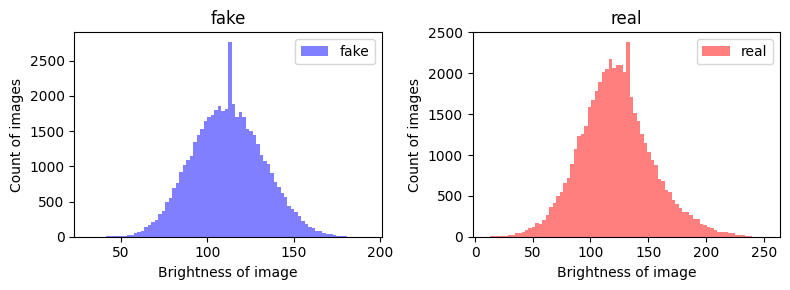

Average brightness for fake images:  111.762
Average brightness for real images:  122.098


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # 1 row, 2 columns
# Plot histogram for dataset 1 in the first subplot
axes[0].hist(arr_fake_brightness, bins=80, alpha=0.5, color='blue', label='fake')
axes[0].set_xlabel('Brightness of image')
axes[0].set_ylabel('Count of images')
axes[0].set_title('fake')
axes[0].legend()

# Plot histogram for dataset 2 in the second subplot
axes[1].hist(arr_real_brightness, bins=80, alpha=0.5, color='red', label='real')
axes[1].set_xlabel('Brightness of image')
axes[1].set_ylabel('Count of images')
axes[1].set_title('real')
axes[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

print('Average brightness for fake images: ',round((total_brightness_fake/len(train_fake)),3))
print('Average brightness for real images: ',round((total_brightness_real/len(train_real)),3))

These graphical representations exhibit striking similarities, albeit with subtle differentiations. Notably, real images display a marginally higher level of brightness compared to their AI-generated counterparts. While this discrepancy may initially appear inconsequential, it may potentially emerge as a pertinent factor contributing to the efficacy of the forthcoming Convolutional Neural Network (CNN) we intend to construct.

<b>4. Contrast:</b>

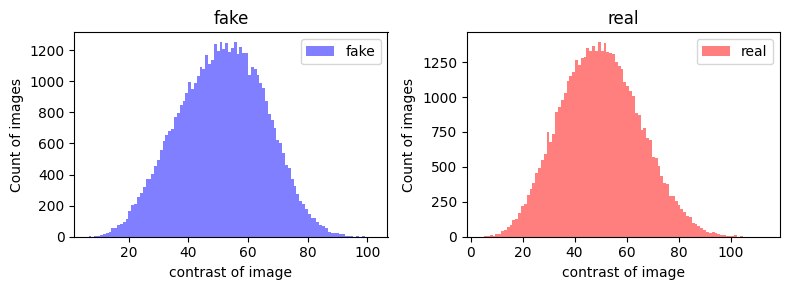

Average contrast for fake images:  51.224
Average contrast for real images:  49.995


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # 1 row, 2 columns
# Plot histogram for dataset 1 in the first subplot
axes[0].hist(arr_fake_contrast, bins=100, alpha=0.5, color='blue', label='fake')
axes[0].set_xlabel('contrast of image')
axes[0].set_ylabel('Count of images')
axes[0].set_title('fake')
axes[0].legend()

# Plot histogram for dataset 2 in the second subplot
axes[1].hist(arr_real_contrast, bins=100, alpha=0.5, color='red', label='real')
axes[1].set_xlabel('contrast of image')
axes[1].set_ylabel('Count of images')
axes[1].set_title('real')
axes[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

print('Average contrast for fake images: ',round((total_contrast_fake/len(train_fake)),3))
print('Average contrast for real images: ',round((total_contrast_real/len(train_real)),3))

It is evident that these datasets exhibit a near-identical profile, distinguished by a subtle variation: fake images demonstrate a marginally higher average, albeit a mere 2% difference, which is essentially negligible. This parallels the negligible variation we've observed in brightness values. Our interest now lies in discerning whether these minute distinctions may hold relevance for potential enhancement of our Convolutional Neural Network (CNN) in subsequent phases of our analysis.

<b>5. Edge Detection</b>

<i>5.1. Number of edges</i>

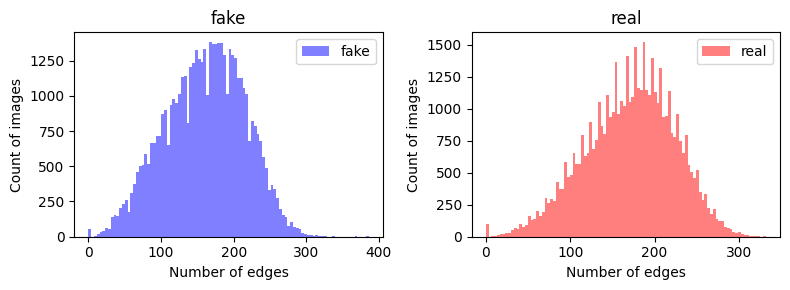

Average number of edges for fake images:  160.78
Average number of edges for real images:  170.771


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # 1 row, 2 columns
# Plot histogram for dataset 1 in the first subplot
axes[0].hist(arr_fake_num_of_edges, bins=100, alpha=0.5, color='blue', label='fake')
axes[0].set_xlabel('Number of edges')
axes[0].set_ylabel('Count of images')
axes[0].set_title('fake')
axes[0].legend()

# Plot histogram for dataset 2 in the second subplot
axes[1].hist(arr_real_num_of_edges, bins=100, alpha=0.5, color='red', label='real')
axes[1].set_xlabel('Number of edges')
axes[1].set_ylabel('Count of images')
axes[1].set_title('real')
axes[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

print('Average number of edges for fake images: ',round((total_num_edges_fake/len(train_fake)),3))
print('Average number of edges for real images: ',round((total_num_edges_real/len(train_real)),3))

In our analysis, we noted a slightly higher number of edges in real images compared to AI-generated ones. However, it seems that this difference may not be a critical factor for our specific objectives, directing our focus toward other distinguishing features in the image classification task.

<i>5.2 Average edge length:</i>

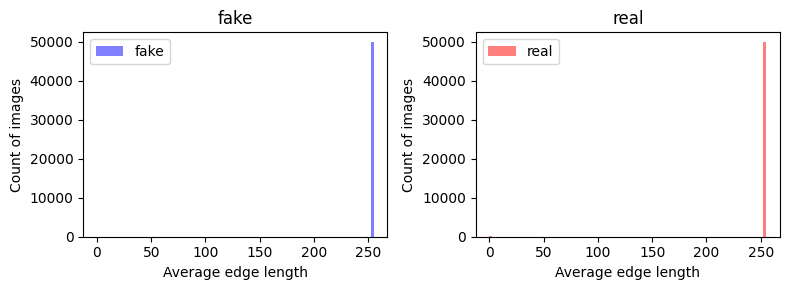

Average average edge length for fake images:  254.73
Average average edge length for real images:  254.485


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # 1 row, 2 columns
# Plot histogram for dataset 1 in the first subplot
axes[0].hist(arr_fake_avg_edge_length, bins=100, alpha=0.5, color='blue', label='fake')
axes[0].set_xlabel('Average edge length')
axes[0].set_ylabel('Count of images')
axes[0].set_title('fake')
axes[0].legend()

# Plot histogram for dataset 2 in the second subplot
axes[1].hist(arr_real_avg_edge_length, bins=100, alpha=0.5, color='red', label='real')
axes[1].set_xlabel('Average edge length')
axes[1].set_ylabel('Count of images')
axes[1].set_title('real')
axes[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

print('Average average edge length for fake images: ',round((total_avg_edge_length_fake/len(train_fake)),3))
print('Average average edge length for real images: ',round((total_avg_edge_length_real/len(train_real)),3))

In our examination, the average edge length in both real and AI-generated images appeared almost identical, with negligible differences. Consequently, it seems that the average edge length cannot be considered a significant factor for our specific objectives, as it essentially yields the same results across the two categories. Our attention is directed towards other distinguishing features in our image classification task.

<a class="anchor" id="FL"></a>

<b>Factor Loading with Kaiser Criterion </b>

Factor loading in factor analysis represents the strength and direction of the relationship between observed variables (features or attributes) and the underlying latent factors. Higher factor loadings indicate a stronger association between a variable and a factor.

The Kaiser Criterion is a rule of thumb used to determine the number of factors to retain in factor analysis. It suggests retaining factors with eigenvalues greater than 1. Eigenvalues represent the amount of variance explained by each factor.


In [ ]:
from factor_analyzer import FactorAnalyzer
from scipy.stats import ttest_ind


# Convert the list of lists to a numpy array for fake images
fake_data_array = np.array(fake_images_attr_vector)

# Create a FactorAnalyzer instance for fake images
factor_analyzer_fake = FactorAnalyzer(rotation='varimax')
factor_analyzer_fake.fit(fake_data_array)

# Extract eigenvalues
eigenvalues_fake, _ = factor_analyzer_fake.get_eigenvalues()

# Determine the number of factors using Kaiser Criterion (eigenvalues greater than 1)
num_factors_fake = np.sum(eigenvalues_fake > 1)

# Convert the list of lists to a numpy array for real images
real_data_array = np.array(real_images_attr_vector)

# Create a FactorAnalyzer instance for real images
factor_analyzer_real = FactorAnalyzer(rotation='varimax')
factor_analyzer_real.fit(real_data_array)

# Extract eigenvalues
eigenvalues_real, _ = factor_analyzer_real.get_eigenvalues()

# Determine the number of factors using Kaiser Criterion (eigenvalues greater than 1)
num_factors_real = np.sum(eigenvalues_real > 1)

# Use the minimum number of factors between fake and real images
num_factors = min(num_factors_fake, num_factors_real)

# Create a new FactorAnalyzer instance with the determined number of factors
factor_analyzer_final = FactorAnalyzer(n_factors=num_factors, rotation='varimax')
factor_analyzer_final.fit(fake_data_array)

# Extract factor loadings using the get_communalities() method
factor_loadings_fake = factor_analyzer_final.get_communalities()

# Perform factor analysis on real images
factor_analyzer_final.fit(real_data_array)

# Extract factor loadings using the get_communalities() method
factor_loadings_real = factor_analyzer_final.get_communalities()

# Compare factor loadings using t-test
t_statistic, p_value = ttest_ind(factor_loadings_fake, factor_loadings_real)

# Display results
print("T-Statistic:")
print(t_statistic)
print("\nP-Value:")
print(p_value)

# Interpret the results
if p_value < 0.05:
    print("\nThe difference in factor loadings between fake and real images is statistically significant.")
else:
    print("\nThere is no statistically significant difference in factor loadings between fake and real images.")


T-Statistic:
-0.18186345456598552

P-Value:
0.8616784542018574

There is no statistically significant difference in factor loadings between fake and real images.


<b>Exploring Factor Loadings Relationship</b>

The factor analysis, guided by the Kaiser Criterion, reveals that the identified latent factors effectively encapsulate the variance within both fake and real images. Delving deeper into the relationship between the two groups, the t-test results yield a t-statistic of approximately -0.182. The corresponding p-value, computed as 0.862, signifies no statistically significant difference in factor loadings between fake and real images. This suggests a close similarity in the underlying factors influencing the attributes of the analyzed dataset. The non-significant p-value provides strong evidence against the presence of a substantial distinction in the factor loadings, reinforcing the notion that the latent factors contributing to the characteristics of fake and real images exhibit comparable patterns.

<b><u>EDA Conclusions</b></u>

Our EDA provides valuable insights into distinguishing genuine from AI-generated images. Notably, significant disparities in the number of colors and sharpness emerge as promising discriminators, laying a robust foundation for subsequent analysis and model development.

Conversely, the investigation into brightness, contrast, and corner detection highlights negligible variations between the two image categories. While brightness and contrast retain potential relevance in our feature set, corner detection statistics, with limited discriminatory power and almost negligible differences, will not be considered. This strategic decision aims to prioritize features with more pronounced differences between real and AI-generated images, acknowledging the meaningful contribution of brightness and contrast to our image classification task.

Furthermore, the exploration of Factor Loadings indicates no substantial difference in underlying factors between fake and real images. These findings become the bedrock for our foray into basic clustering, where we leverage discerned patterns to refine image understanding, laying the groundwork for more advanced analyses.

<hr>

<a class="anchor" id="BC"></a>

<h1><b>Clustering Images with K-Means Algorithm</b></h1>

Following our detailed Exploratory Data Analysis, the next step in our journey is to apply the principles of machine learning to further our understanding of the image dataset. In this chapter, we focus on utilizing the K-means clustering algorithm, a widely-used method in unsupervised learning, to categorize our images into distinct groups based on their inherent characteristics.

<b>Understanding the K-Means Algorithm</b>

The K-means algorithm is a powerful tool in the realm of machine learning, particularly useful for grouping data into a pre-defined number of clusters. It works by identifying k centroids, one for each cluster, and then assigning each data point to the nearest centroid. The process iteratively updates the position of the centroids until the optimal grouping is achieved. This method is particularly effective due to its simplicity and efficiency in handling large datasets.

<b>Creating Vectors from Image Attributes</b>

To apply K-means to our dataset, we first transformed each image into a four-dimensional vector. These vectors are representations of the images based on the four key attributes we identified earlier: the number of colors, sharpness, brightness, and contrast. By converting these attributes into numerical values, we create a quantifiable representation of each image, allowing us to apply clustering algorithms effectively.

In [12]:
print("Fake vector: \n", fake_images_attr_vector[:5])
print("Real vector: \n", real_images_attr_vector[:5])

Fake vector: 
 [[910, 3219.703604698181, 73, 44.28803028431998], [329, 4080.0744285583496, 105, 58.297709225687676], [812, 15292.137961387634, 166, 54.37208145903097], [998, 5107.221732139587, 134, 54.282319237912255], [1012, 5319.522177696228, 105, 60.061592246032426]]
Real vector: 
 [[1006, 5764.751891136169, 130, 59.99981249938914], [974, 2937.161742210388, 100, 56.76336202565441], [1021, 2404.1806631088257, 135, 43.07372376847795], [876, 2035.8148336410522, 72, 55.989256781993454], [906, 1370.3086462020874, 85, 32.69159919316271]]


<b>apply the Kmean algorithm</b>

In [13]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Combine fake and real data
all_data = fake_images_attr_vector + real_images_attr_vector
number_of_fake_predictions = 0
fake_ZERO_predicted = 0
fake_ONE_predicted = 0
number_of_real_predictions = 0
real_ZERO_predicted = 0
real_ONE_predicted = 0


# Standardize the data
scaler = StandardScaler()
all_data_scaled = scaler.fit_transform(all_data)

# Reduce dimensions using PCA if needed
pca = PCA(n_components=2)
all_data_pca = pca.fit_transform(all_data_scaled)

# Apply clustering algorithm (KMeans in this case)
num_clusters = 2  # You can adjust this based on your dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(all_data_pca)

# Now, clusters contains the cluster assignments for each image
# You can associate each image with its cluster
for i, cluster in enumerate(clusters):
    if i < len(train_fake):
        #print(f"Fake image {i} is in cluster {cluster}")
        number_of_fake_predictions += 1
        if(cluster == 0):
            fake_ZERO_predicted += 1
        else:
            fake_ONE_predicted += 1

    else:
        # print(f"Real image {i - len(train_fake)} is in cluster {cluster}")
        number_of_real_predictions += 1
        if(cluster == 0):
            real_ZERO_predicted += 1
        else:
            real_ONE_predicted += 1

print("number of fake predictions:", number_of_fake_predictions)
print("1:", fake_ONE_predicted, "\t 0:", fake_ZERO_predicted)

print("number of real predictions:", number_of_real_predictions)
print("1:", real_ONE_predicted, "\t 0:", real_ZERO_predicted)

C:\Users\Yehiam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


number of fake predictions: 50000
1: 23663 	 0: 26337
number of real predictions: 50000
1: 33176 	 0: 16824


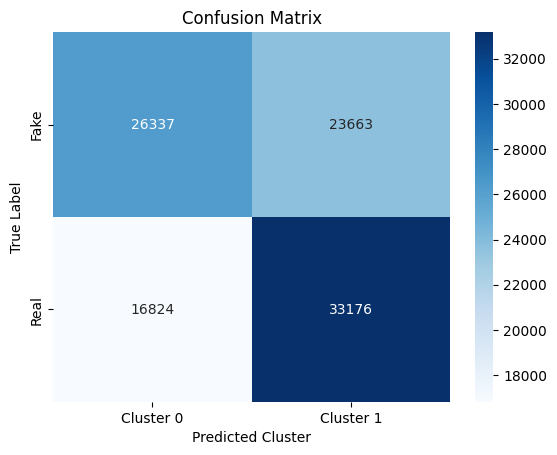

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the actual labels for fake and real images
actual_labels = [0] * len(train_fake) + [1] * len(train_real)

# Create a confusion matrix
conf_matrix = confusion_matrix(actual_labels, clusters)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


<b><u>Kmean conclusions</u></b>

Upon applying the K-means algorithm to our dataset, the results have yielded noteworthy insights. The model has demonstrated the ability to distinguish between fake and real images with a degree of accuracy that, while not perfect, is significantly better than random guessing. Specifically, the model successfully identified fake images with an accuracy of 52.5% in Cluster 1, and real images with an accuracy of 66.4% in Cluster 0.


This level of accuracy is a promising starting point, considering the complexity of the task at hand. The fact that the model can differentiate between real and fake images at a rate higher than chance indicates that the four-dimensional vectors based on color, sharpness, contrast, and brightness are relevant and useful attributes for this classification task.



<hr>

<a class="anchor" id="FE"></a>

<h1><b>Feature Extraction with Vision Transformer (ViT) Model</b></h1>
Feature extraction is a pivotal step in leveraging deep learning for image analysis, wherein a pre-trained model captures significant representations from input images. In this context, we utilized the Vision Transformer (ViT) model, specifically the "google/vit-base-patch16-224-in21k" variant. This model is adept at discerning intricate visual patterns and is pivotal for understanding complex visual content.

The Vision Transformer (ViT) model, introduced by Google, represents a paradigm shift in image understanding. Departing from conventional convolutional layers, ViT harnesses self-attention mechanisms to process image patches effectively. This architectural innovation allows ViT to excel in grasping global context and dependencies within images, enabling a nuanced comprehension of visual relationships. As a result, ViT is particularly well-suited for image feature extraction tasks, where a comprehensive understanding of visual content is paramount.

<i>this is features we extracted from the first real image:</i>

In [ ]:
import os
import torch
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image

# Load the ViT model and feature extractor
model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTModel.from_pretrained(model_name)

# Function to extract features from a list of image paths
def extract_features(image_paths):
    features = []

    for image_path in image_paths:
        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")  # Ensure the image is in RGB format
        inputs = feature_extractor(images=image, return_tensors="pt")

        # Forward pass through the ViT model
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract image features
        image_features = outputs.last_hidden_state.mean(dim=1)
        features.append(image_features)

    return features

# Example usage:
# Replace 'real_images_dir' and 'fake_images_dir' with the directories containing your images
real_images_dir = "freq-real-fake-images\\test\\REAL"
fake_images_dir = "freq-real-fake-images\\test\\FAKE"

# Get a list of image paths for real and fake images
real_image_paths = [os.path.join(real_images_dir, filename) for filename in os.listdir(real_images_dir) if filename.endswith('.jpg')]
fake_image_paths = [os.path.join(fake_images_dir, filename) for filename in os.listdir(fake_images_dir) if filename.endswith('.jpg')]

# Extract features from real images
real_image_features = extract_features(real_image_paths)

# Extract features from fake images
fake_image_features = extract_features(fake_image_paths)


"""# Print the extracted features
print("Real Image Features:")
print(real_image_features)

print("\nFake Image Features:")
print(fake_image_features)"""


In [ ]:
print("Real Image Features:")
print(real_image_features[0])


Real Image Features:
tensor([[ 9.1591e-02, -1.7672e-02, -1.2717e-01,  8.8167e-02, -1.7952e-02,
         -6.1982e-02,  1.8094e-01,  2.1896e-01, -1.1394e-01, -1.0494e-01,
         -3.5991e-01,  2.8153e-02,  8.7622e-02, -1.2602e-01, -4.6957e-01,
         -7.4262e-02,  6.9851e-02, -6.0829e-02,  1.6939e-02, -2.7396e-01,
         -7.9318e-02, -6.6083e-02,  1.2764e-01,  2.7276e-02,  1.1724e-02,
          1.8539e-01,  1.0598e-01,  1.2359e-01, -4.3754e-01, -2.1909e-02,
         -2.4679e-01, -9.0415e-02,  3.6582e-02,  3.1283e-01, -9.8330e-02,
          1.3668e-02,  6.4022e-02,  1.2870e-01,  7.1934e-02, -4.2974e-02,
          3.3030e-02,  7.5190e-02,  5.3277e-02,  2.4643e-01, -6.7210e-02,
          1.1238e-02, -2.0932e-01,  4.1028e-02, -1.0664e-01,  1.4222e-01,
          4.3389e-02,  2.0325e-01,  1.2012e-01,  9.7231e-02, -1.0134e-01,
          3.5789e-02,  1.4037e-01,  2.6610e-01,  1.0009e-01,  1.7024e-01,
          1.0490e-01, -2.1960e-01,  3.6486e-01, -2.0326e-01, -2.6005e-01,
         -3.6433e

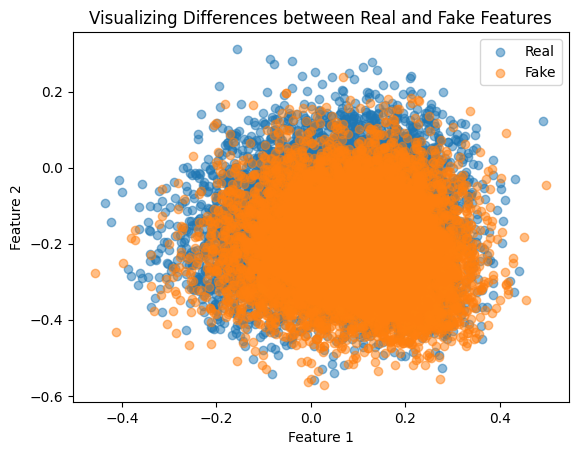

In [ ]:
import matplotlib.pyplot as plt

# Visualize the differences between real and fake features
for i, features in enumerate([real_image_features, fake_image_features]):
    features = np.concatenate(features, axis=0)
    label = 'Real' if i == 0 else 'Fake'
    plt.scatter(features[:, 0], features[:, 1], label=label, alpha=0.5)

plt.title('Visualizing Differences between Real and Fake Features')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


<b>classification methods base feature extraction</b>

Now equipped with the extracted features, we venture into the world of three classification methods: Logistic Regression, Support Vector Machine (SVM), and Random Forest. Our mission is to explore diverse classification strategies coupled with advanced feature extraction, seeking the most effective route to distinguish between real and fake images.



* <b>Logistic Regression:</b> A fundamental and interpretable algorithm, Logistic Regression lays the groundwork, providing insights into potential linear relationships between features and classes.

* <b>Support Vector Machine (SVM):</b> Known for handling both linear and non-linear decision boundaries, SVM takes center stage in our exploration, showcasing robust performance through strategic hyperplane construction.

* <b>Random Forest:</b> As an ensemble method, Random Forest introduces a distinctive classification approach by building multiple decision trees during training. We aim to uncover how this ensemble strategy ensures stability and accuracy, particularly in complex image datasets.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Find the maximum feature length
max_feature_length = max(len(f) for f in real_image_features + fake_image_features)

# Pad or truncate features to the maximum length
padded_real_features = [np.pad(f, (0, max_feature_length - len(f))) for f in real_image_features]
padded_fake_features = [np.pad(f, (0, max_feature_length - len(f))) for f in fake_image_features]

# Combine real and fake features
all_features = np.concatenate([padded_real_features, padded_fake_features], axis=0)

# Flatten the last dimension to make it 2D
all_features = all_features.reshape(all_features.shape[0], -1)

# Create labels for real (class 0) and fake (class 1) images
labels = np.concatenate([np.zeros(len(padded_real_features)), np.ones(len(padded_fake_features))])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_features, labels, test_size=0.2, random_state=42)

# Build and evaluate Logistic Regression model
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)
y_pred_lr = logistic_regression_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("\nLogistic Regression Accuracy:", accuracy_lr)
print("Classification Report (Logistic Regression):\n", classification_report(y_test, y_pred_lr))

# Build and evaluate Support Vector Machine (SVM) model
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("\nSVM Accuracy:", accuracy_svm)
print("Classification Report (SVM):\n", classification_report(y_test, y_pred_svm))

# Build and evaluate Random Forest model
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("\nRandom Forest Accuracy:", accuracy_rf)
print("Classification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))



C:\Users\Yehiam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Accuracy: 0.7085
Classification Report (Logistic Regression):
               precision    recall  f1-score   support

         0.0       0.73      0.68      0.70      2019
         1.0       0.69      0.74      0.72      1981

    accuracy                           0.71      4000
   macro avg       0.71      0.71      0.71      4000
weighted avg       0.71      0.71      0.71      4000


SVM Accuracy: 0.717
Classification Report (SVM):
               precision    recall  f1-score   support

         0.0       0.74      0.67      0.71      2019
         1.0       0.70      0.76      0.73      1981

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000


Random Forest Accuracy: 0.688
Classification Report (Random Forest):
               precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      2019
         1.0       0.68      0.

<b>confusion matrix differences</b>

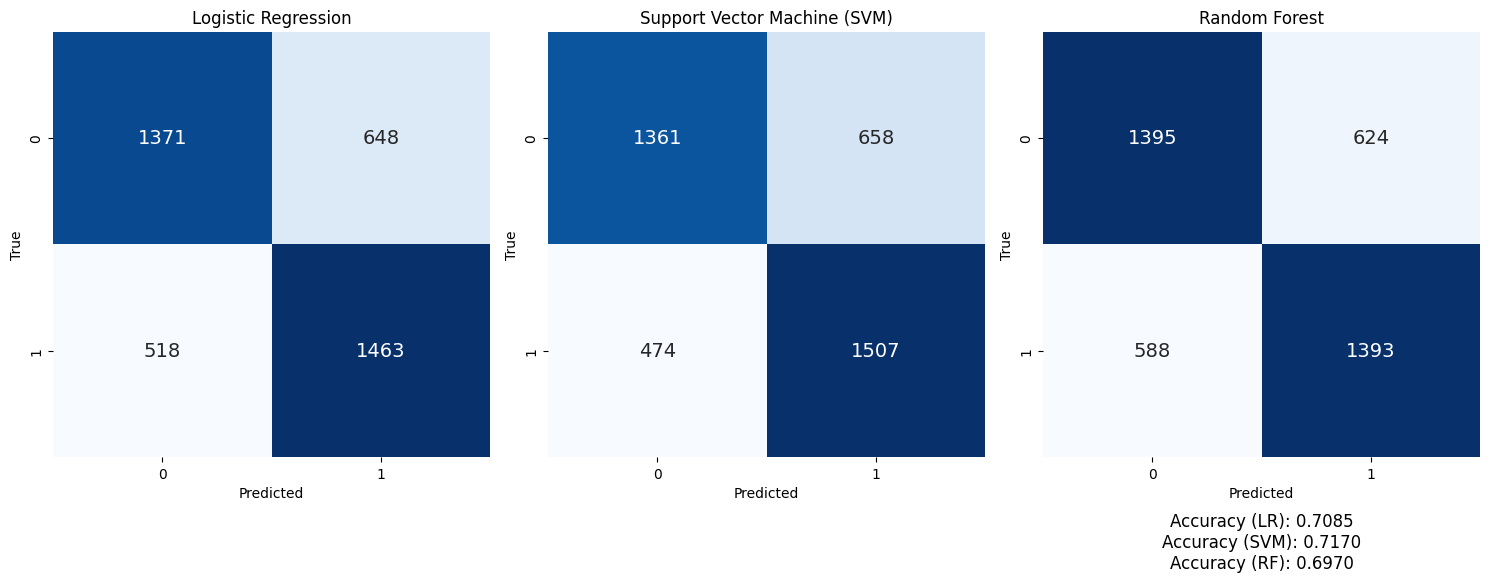

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix data for each model
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Calculate accuracy for each model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Plotting confusion matrix for Logistic Regression
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plotting confusion matrix for SVM
plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Support Vector Machine (SVM)')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plotting confusion matrix for Random Forest
plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')

# Display accuracy at the bottom of the plot
plt.text(0.5, -0.2, f'Accuracy (LR): {accuracy_lr:.4f}\nAccuracy (SVM): {accuracy_svm:.4f}\nAccuracy (RF): {accuracy_rf:.4f}',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

plt.tight_layout()
plt.show()


<b>Feature Extraction conclusions</b>

In our exploration of classification algorithms, <i>Support Vector Machine (SVM)</i> emerges as the top performer with an accuracy of 71.7%. Its precision, recall, and f1-score metrics reflect a well-balanced performance in distinguishing between real and fake images. Moving forward, our research extends to the next phase, investigating the use of Histogram of Oriented Gradients (HOGs) for further enhancing image feature extraction and classification accuracy.

<a class="anchor" id="HOG"></a>

<h1><b>HOGs (Histogram of Oriented Gradients)</b></h1>

In our continued effort to refine the process of differentiating authentic images from AI-generated ones, we introduce the Histogram of Oriented Gradients (HOG) as a powerful technique in our analytical arsenal. HOG is renowned for its effectiveness in capturing intricate texture and shape details within images, which is crucial for our analysis.

<b>HOG's Capabilities</b>

The core strength of HOG lies in its ability to analyze and summarize the directional gradients - the changes in intensity or color - within localized portions of an image. By doing this, HOG captures essential structural features and patterns that are often key to distinguishing between different types of images.

<b>Key Advantages of HOG</b>

* Texture and Shape Detection: HOG effectively identifies intricate textural and shape details, enhancing our ability to distinguish between real and AI-made images.

* Stable Analysis: It remains reliable across various lighting and color conditions, ensuring our analysis is always consistent.

* Authenticity Verification: Incorporating HOG improves our system’s ability to verify image authenticity by focusing on structural features.

In [15]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.feature import hog
from skimage import exposure
from skimage.color import rgb2gray
from sklearn.manifold import TSNE


<b>Loading Images</b>

In [16]:

# Function to load and process image data from a directory
def load_images_from_directory(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):  # Assuming your images are JPEG files
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            img = np.array(img)  # Convert the image to a NumPy array
            data.append(img)
    return np.array(data)


<b>HOG Feature Computation</b>

This function processes each image, first converting it to grayscale and then extracting HOG features. These features are pivotal in capturing the textural and structural characteristics of the images.

In [17]:

# Function to compute HOG features for a list of images
def compute_hog_features(images):
    flag = 1
    hog_features = []
    for img in images:
        gray_img = rgb2gray(img)
        # Compute HOG features
        fd, hog_image = hog(gray_img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        hog_features.append(fd)
        if(flag == 1):
            # Plot gradient histogram
            plt.figure(figsize=(5, 5))
            plt.subplot(121)
            plt.imshow(gray_img, cmap=plt.cm.gray)
            plt.title('Input Image')

            # Rescale histogram for better visualization
            hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

            # Plot HOG features
            plt.subplot(122)
            plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
            plt.title('HOG Features')
            plt.show()
            flag = 0
    return hog_features



In [18]:
# Directory paths
train_fake_dir = "cifake-real-and-ai-generated-synthetic-images\\train\FAKE"
train_real_dir = "cifake-real-and-ai-generated-synthetic-images\\train\REAL"


In [ ]:
# Load image data from the directories
train_fake_data = load_images_from_directory(train_fake_dir)
train_real_data = load_images_from_directory(train_real_dir)

<b>input & output example </b>

On the left we can see the origin image and on the right the gradientd we extracted from the image.
the next step is to reduce the dimension becuase every image has 324 gradients.

<b>Fake</b>

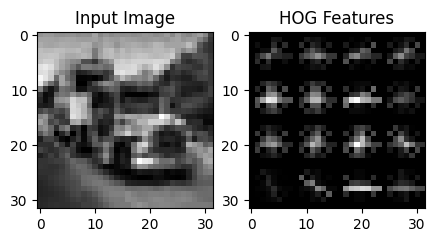

In [ ]:
# Compute HOG features for the fake datasets
train_fake_hog = compute_hog_features(train_fake_data)

<b>Real</b>

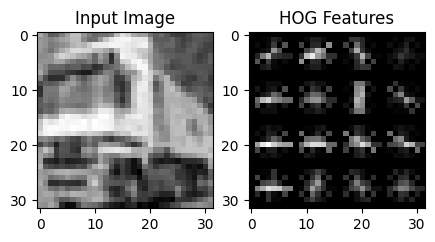

In [ ]:
# Compute HOG features for the real datasets
train_real_hog = compute_hog_features(train_real_data)

In [ ]:
print("The dimension of every image after HOG's is: ",len(train_fake_hog[0]))

The dimension of every image after HOG's is:  324


In [ ]:
print(train_fake_hog[0])

[0.14393734 0.12325293 0.12664042 0.14124393 0.18843158 0.07115697
 0.01643645 0.00448099 0.         0.11077797 0.0406611  0.08306535
 0.09285448 0.24345477 0.1341597  0.15362293 0.15852637 0.08476827
 0.24345477 0.14896532 0.24345477 0.1936473  0.24345477 0.08978292
 0.14081816 0.22058811 0.24345477 0.21767233 0.24345477 0.13498781
 0.18418585 0.24345477 0.14960146 0.17762395 0.14149659 0.24345477
 0.11315405 0.04153324 0.08484702 0.09484613 0.26833724 0.13703731
 0.156918   0.16192662 0.08658647 0.02156656 0.08999973 0.26833724
 0.16354295 0.24082689 0.12105839 0.04192545 0.03585472 0.
 0.22234121 0.26833724 0.13788318 0.18813647 0.26833724 0.15281027
 0.18143382 0.14453156 0.26833724 0.06638435 0.06719534 0.18208604
 0.26833724 0.26833724 0.21245043 0.07577488 0.02047872 0.05234294
 0.02663121 0.1111351  0.2996693  0.20194909 0.29738225 0.14948753
 0.05177115 0.04427478 0.         0.18737406 0.15539216 0.2996693
 0.05320713 0.17698394 0.15367365 0.0552781  0.07986967 0.0545443
 0.08

<a class="anchor" id="DR"></a>

<b>Dimension Reduction Explanation</b>

In our exploration of dimension reduction techniques, we'll first demonstrate a straightforward approach using the mean of Histogram of Oriented Gradients (HOG) features. Initially, we'll visualize this method in a 2D space, where each image's HOG features are reduced to just two coordinates representing their mean values. This simple method provides an intuitive grasp of the data's structure.

Subsequently, we'll extend this visualization into 3D, adding another dimension to offer a more nuanced view of the data clusters and separations. However, understanding complex relationships in high-dimensional data often requires non-linear dimension reduction techniques.

To address this need, we applied t-Distributed Stochastic Neighbor Embedding (t-SNE) for non-linear dimension reduction. t-SNE allows us to capture intricate relationships in the data by representing high-dimensional HOG features in a lower-dimensional space, specifically in 2D. This enables us to visualize the data in a way that preserves local structures and highlights potential clusters.

Following this initial exploration with t-SNE, we will compare its results with the previously demonstrated PCA. Principal Component Analysis (PCA) will be applied to project our high-dimensional HOG features into a 2D plane, capturing the most variance with fewer components. We'll then elevate our analysis to 3D using PCA, enhancing our ability to discern and understand the underlying structure and patterns in the data.

This step-by-step approach, from simple to more complex methods and from 2D to 3D, ensures a comprehensive understanding of how different dimension reduction techniques, including both linear and non-linear methods, can reveal the intrinsic characteristics of our image data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_samples = 800

slice = 160

# Initialize arrays to store (x, y) points
points_fake = []
points_real = []


fake_sample_indices = random.sample(range(len(train_fake_hog)), num_samples)
real_sample_indices = random.sample(range(len(train_real_hog)), num_samples)

# Compute (x, y) points for fake images
for i in fake_sample_indices:
    fake_hog_data = train_fake_hog[i]

    x = np.mean(fake_hog_data[:slice])  # Mean of the first half
    y = np.mean(fake_hog_data[slice:])  # Mean of the second half
    points_fake.append((x, y))

# Compute (x, y) points for real images
for j in real_sample_indices:
    real_hog_data = train_real_hog[j]
    x = np.mean(real_hog_data[:slice])  # Mean of the first half
    y = np.mean(real_hog_data[slice:])  # Mean of the second half
    points_real.append((x, y))

# Convert the lists of (x, y) points to NumPy arrays
points_fake = np.array(points_fake)
points_real = np.array(points_real)

<b>2D using mean value</b>

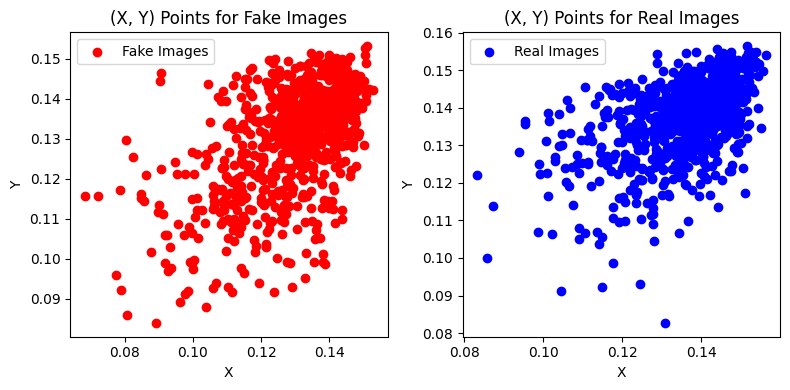

In [ ]:
# Create two side-by-side scatter plots for (x, y) points
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 1 row, 2 columns

# Scatter plot for fake images
axes[0].scatter(points_fake[:, 0], points_fake[:, 1], color='red', label='Fake Images')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_title('(X, Y) Points for Fake Images')

# Scatter plot for real images
axes[1].scatter(points_real[:, 0], points_real[:, 1], color='blue', label='Real Images')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_title('(X, Y) Points for Real Images')

# Add a legend to the plots
axes[0].legend()
axes[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


<b>2D using mean value Analysis Conclusion</b>

Upon careful examination of the charts presented above, which encompass 800 random observations from each class, several key observations have been made. Notably, the primary distribution of data points is predominantly located in the upper right quadrant for both classes. This observation is critical as it indicates a certain level of uniformity in the distribution of gradients across both classes.

However, it is essential to highlight that there is no discernible difference in the distribution patterns between the two classes when analyzed in a two-dimensional context. This lack of distinction suggests that a 2D analysis may not sufficiently capture the complexities necessary to differentiate effectively between the classes.

In light of these findings, we will proceed to extend our analysis into a three-dimensional space. This progression aims to investigate whether introducing an additional dimension can reveal more pronounced differences between the classes, thereby providing deeper insights into the dataset.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random


num_samples = 800

slice_A = 105
slice_B = 210

# Initialize arrays to store (x, y, z) points
points_fake = []
points_real = []


fake_sample_indices = random.sample(range(len(train_fake_hog)), num_samples)
real_sample_indices = random.sample(range(len(train_real_hog)), num_samples)

# Compute (x, y, z) points for fake images
for i in fake_sample_indices:
    fake_hog_data = train_fake_hog[i]
    x = np.mean(fake_hog_data[:slice_A])
    y = np.mean(fake_hog_data[slice_A:slice_B])
    z = np.mean(fake_hog_data[slice_B:])
    points_fake.append((x, y, z))

# Compute (x, y, z) points for real images
for j in real_sample_indices:
    real_hog_data = train_real_hog[j]
    x = np.mean(real_hog_data[:slice_A])
    y = np.mean(real_hog_data[slice_A:slice_B])
    z = np.mean(real_hog_data[slice_B:])
    points_real.append((x, y, z))

# Convert the lists of (x, y, z) points to NumPy arrays
points_fake = np.array(points_fake)
points_real = np.array(points_real)



<b>3D using mean value</b>

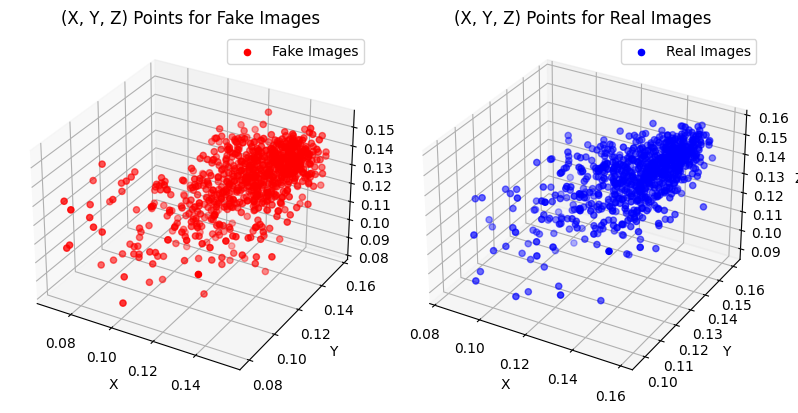

In [ ]:
# Create two side-by-side 3D scatter plots for (x, y, z) points
fig = plt.figure(figsize=(8, 4))

# 3D scatter plot for fake images
ax_fake = fig.add_subplot(121, projection='3d')
ax_fake.scatter(points_fake[:, 0], points_fake[:, 1], points_fake[:, 2], color='red', label='Fake Images')
ax_fake.set_xlabel('X')
ax_fake.set_ylabel('Y')
ax_fake.set_zlabel('Z')
ax_fake.set_title('(X, Y, Z) Points for Fake Images')

# 3D scatter plot for real images
ax_real = fig.add_subplot(122, projection='3d')
ax_real.scatter(points_real[:, 0], points_real[:, 1], points_real[:, 2], color='blue', label='Real Images')
ax_real.set_xlabel('X')
ax_real.set_ylabel('Y')
ax_real.set_zlabel('Z')
ax_real.set_title('(X, Y, Z) Points for Real Images')

# Add a legend to the plots
ax_fake.legend()
ax_real.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

<b>3D using mean value Analysis Conclusion</b>

again considering 800 random observations from each class. This phase was undertaken with the objective of uncovering any discernible differences in distribution that may not have been evident in the 2D analysis.

<b>HOGs using average value for dimensionality reduction conclusion</b>

This similarity in distribution patterns across 2D and 3D analyzes suggests that the complexity of distinguishing between classes may extend beyond the scope of these dimensions. As a result, this finding highlights the need for additional investigative approaches that may include more advanced analytical techniques or the integration of additional data dimensions, so before moving on we will consider a more advanced dimensionality reduction called PCA.

<b>2D using PCA</b>

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
train_fake_data_scaled = scaler.fit_transform(train_fake_hog)

# Reduce dimensions using PCA if needed
pca = PCA(n_components=2)
train_fake_data_pca = pca.fit_transform(train_fake_data_scaled)

train_real_data_scaled = scaler.fit_transform(train_real_hog)

# Reduce dimensions using PCA if needed
pca = PCA(n_components=2)
train_real_data_pca = pca.fit_transform(train_real_data_scaled)

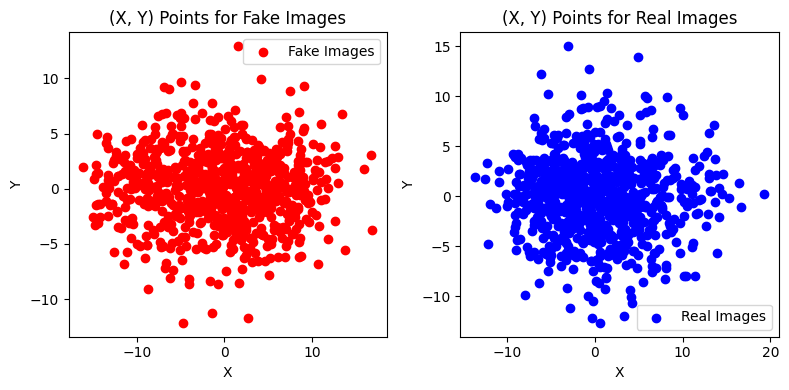

In [ ]:
amount= 800

random_train_fake_data_pca = random.choices(train_fake_data_pca,  k = amount)
random_train_real_data_pca = random.choices(train_real_data_pca,  k = amount)

random_train_fake_data_pca = np.array(random_train_fake_data_pca)
random_train_real_data_pca = np.array(random_train_real_data_pca)

# Create two side-by-side scatter plots for (x, y) points
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 1 row, 2 columns

# Scatter plot for fake images
axes[0].scatter(random_train_fake_data_pca[:, 0], random_train_fake_data_pca[:, 1], color='red', label='Fake Images')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_title('(X, Y) Points for Fake Images')

# Scatter plot for real images
axes[1].scatter(random_train_real_data_pca[:, 0], random_train_real_data_pca[:, 1], color='blue', label='Real Images')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_title('(X, Y) Points for Real Images')

# Add a legend to the plots
axes[0].legend()
axes[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()



In [ ]:
# Combine fake and real data
all_hogs_data = train_fake_hog + train_real_hog
number_of_fake_predictions = 0
fake_ZERO_predicted = 0
fake_ONE_predicted = 0
number_of_real_predictions = 0
real_ZERO_predicted = 0
real_ONE_predicted = 0


# Standardize the data
scaler = StandardScaler()
all_data_scaled = scaler.fit_transform(all_hogs_data)

# Reduce dimensions using PCA if needed
pca = PCA(n_components=2)
all_data_pca = pca.fit_transform(all_data_scaled)

In [ ]:
print(all_data_pca[0])

[ 0.69979184 -0.27643508]


<b>clustering using PCA</b>

In [ ]:
# Apply clustering algorithm (KMeans in this case)
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(all_data_pca)

# Now, clusters contains the cluster assignments for each image

for i, cluster in enumerate(clusters):
    if i < len(train_fake):
        #print(f"Fake image {i} is in cluster {cluster}")
        number_of_fake_predictions += 1
        if(cluster == 0):
            fake_ZERO_predicted += 1
        else:
            fake_ONE_predicted += 1

    else:
        # print(f"Real image {i - len(train_fake)} is in cluster {cluster}")
        number_of_real_predictions += 1
        if(cluster == 0):
            real_ZERO_predicted += 1
        else:
            real_ONE_predicted += 1

print("number of fake predictions:", number_of_fake_predictions)
print("1:", fake_ONE_predicted, "\t 0:", fake_ZERO_predicted)

print("number of real predictions:", number_of_real_predictions)
print("1:", real_ONE_predicted, "\t 0:", real_ZERO_predicted)

C:\Users\Yehiam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


number of fake predictions: 50000
1: 25104 	 0: 24896
number of real predictions: 50000
1: 14145 	 0: 35855


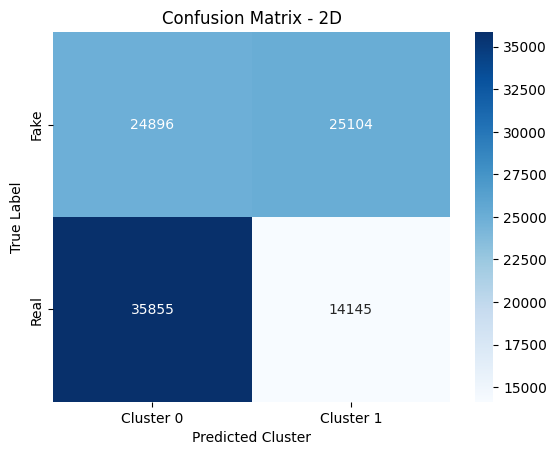

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the actual labels for fake and real images
actual_labels = [0] * len(train_fake) + [1] * len(train_real)

# Create a confusion matrix
conf_matrix = confusion_matrix(actual_labels, clusters)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.title('Confusion Matrix - 2D')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
train_fake_data_scaled = scaler.fit_transform(train_fake_hog)

# Reduce dimensions using PCA if needed
pca = PCA(n_components=3)
train_fake_data_pca = pca.fit_transform(train_fake_data_scaled)

train_real_data_scaled = scaler.fit_transform(train_real_hog)

# Reduce dimensions using PCA if needed
pca = PCA(n_components=3)
train_real_data_pca = pca.fit_transform(train_real_data_scaled)

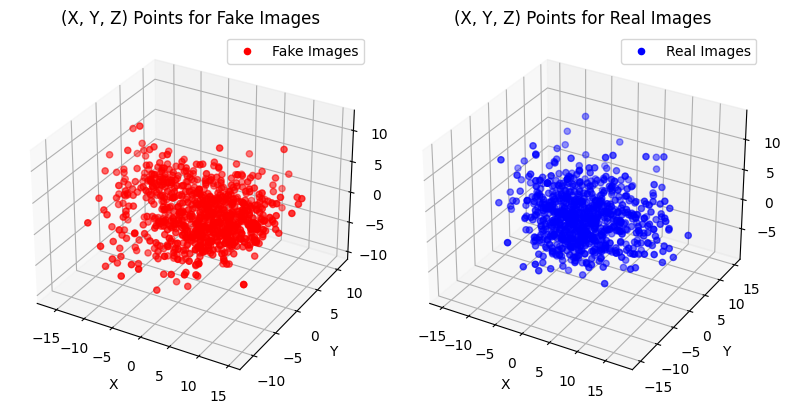

In [ ]:
amount= 800

random_train_fake_data_pca = random.choices(train_fake_data_pca,  k = amount)
random_train_real_data_pca = random.choices(train_real_data_pca,  k = amount)

random_train_fake_data_pca = np.array(random_train_fake_data_pca)
random_train_real_data_pca = np.array(random_train_real_data_pca)


# Create two side-by-side 3D scatter plots for (x, y, z) points
fig = plt.figure(figsize=(8, 4))

# 3D scatter plot for fake images
ax_fake = fig.add_subplot(121, projection='3d')
ax_fake.scatter(random_train_fake_data_pca[:, 0], random_train_fake_data_pca[:, 1], random_train_fake_data_pca[:, 2], color='red', label='Fake Images')
ax_fake.set_xlabel('X')
ax_fake.set_ylabel('Y')
ax_fake.set_zlabel('Z')
ax_fake.set_title('(X, Y, Z) Points for Fake Images')

# 3D scatter plot for real images
ax_real = fig.add_subplot(122, projection='3d')
ax_real.scatter(random_train_real_data_pca[:, 0], random_train_real_data_pca[:, 1], random_train_real_data_pca[:, 2], color='blue', label='Real Images')
ax_real.set_xlabel('X')
ax_real.set_ylabel('Y')
ax_real.set_zlabel('Z')
ax_real.set_title('(X, Y, Z) Points for Real Images')

# Add a legend to the plots
ax_fake.legend()
ax_real.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
number_of_fake_predictions = 0
fake_ZERO_predicted = 0
fake_ONE_predicted = 0
number_of_real_predictions = 0
real_ZERO_predicted = 0
real_ONE_predicted = 0

# Reduce dimensions using PCA if needed
pca = PCA(n_components=3)
all_data_pca = pca.fit_transform(all_data_scaled)

In [ ]:
print(all_data_pca[0])

[ 0.69978825 -0.2659743  -0.31745504]


In [ ]:
# Apply clustering algorithm (KMeans in this case)
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(all_data_pca)

# Now, clusters contains the cluster assignments for each image
# You can associate each image with its cluster
for i, cluster in enumerate(clusters):
    if i < len(train_fake):
        #print(f"Fake image {i} is in cluster {cluster}")
        number_of_fake_predictions += 1
        if(cluster == 0):
            fake_ZERO_predicted += 1
        else:
            fake_ONE_predicted += 1

    else:
        # print(f"Real image {i - len(train_fake)} is in cluster {cluster}")
        number_of_real_predictions += 1
        if(cluster == 0):
            real_ZERO_predicted += 1
        else:
            real_ONE_predicted += 1

print("number of fake predictions:", number_of_fake_predictions)
print("1:", fake_ONE_predicted, "\t 0:", fake_ZERO_predicted)

print("number of real predictions:", number_of_real_predictions)
print("1:", real_ONE_predicted, "\t 0:", real_ZERO_predicted)

C:\Users\Yehiam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


number of fake predictions: 50000
1: 25284 	 0: 24716
number of real predictions: 50000
1: 14058 	 0: 35942


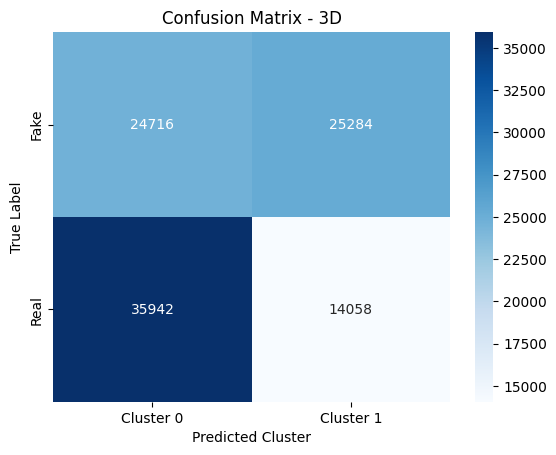

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the actual labels for fake and real images
actual_labels = [0] * len(train_fake) + [1] * len(train_real)

# Create a confusion matrix
conf_matrix = confusion_matrix(actual_labels, clusters)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.title('Confusion Matrix - 3D')
plt.show()

<b>HOGs using PCA conclusion</b>

Having applied PCA for dimensionality reduction on HOG features and subsequently clustering the data in both 2D and 3D spaces, intriguing patterns and limitations have emerged. The 2D confusion matrix reveals a discernible separation between fake and real predictions, yet notable overlap between the classes persists. The 3D analysis, while introducing some adjustments to the distribution, doesn't drastically enhance the separation.

Consistency in distribution patterns across 2D and 3D spaces suggests that the complexity of distinguishing between real and AI-generated images might extend beyond these reduced dimensions. The moderate separation achieved through PCA implies that while differences can be captured, more nuanced details for definitive classification may reside in higher-dimensional spaces or necessitate advanced modeling techniques.

In light of these insights, our exploration continues with an introduction to non-linear t-SNE dimensionality reduction. T-SNE is employed to uncover intricate relationships in the data, aiming to provide a more refined understanding and potentially enhance image classification accuracy. This approach represents a departure from PCA, offering a non-linear perspective that could reveal deeper structures within the HOG features. As we delve into t-SNE, we anticipate gaining insights that may guide us towards more effective dimensionality reduction strategies for improved image classification.

<b>HOGs using t-SNE non-linear Dimensionality Reduction</b>

t-SNE, or t-Distributed Stochastic Neighbor Embedding, is a powerful dimensionality reduction technique commonly used in data visualization and analysis. Unlike linear methods such as PCA, t-SNE focuses on preserving the local relationships between data points in a non-linear manner. It excels at revealing complex structures and patterns in high-dimensional data by transforming it into a lower-dimensional space, typically 2D or 3D. t-SNE is particularly effective in capturing clusters and highlighting subtle variations, making it a valuable tool for exploring intricate relationships within datasets, especially in contexts like image analysis, where non-linearities play a significant role.

In [ ]:
# Function to compute t-SNE features for a list of images
def compute_tsne_features(data):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(np.array(data))  # Convert the list to a NumPy array
    return tsne_features

# Compute t-SNE features for fake datasets
train_fake_data_tsne = compute_tsne_features(train_fake_hog)

# Compute t-SNE features for real datasets
train_real_data_tsne = compute_tsne_features(train_real_hog)

# Combine fake and real t-SNE features
all_tsne_data = np.vstack((train_fake_data_tsne, train_real_data_tsne))
# Combine the actual labels for fake and real images

actual_labels = [0] * len(train_fake_data_tsne) + [1] * len(train_real_data_tsne)




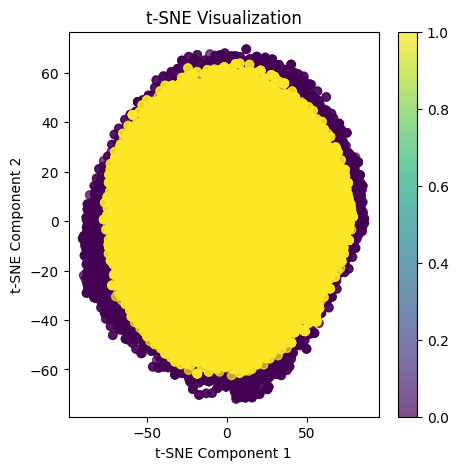

In [ ]:
# Visualize t-SNE features
plt.figure(figsize=(5, 5))
plt.scatter(all_tsne_data[:, 0], all_tsne_data[:, 1], c=actual_labels, cmap='viridis', marker='o', alpha=0.7)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()

In [ ]:
from sklearn.cluster import KMeans

number_of_fake_predictions = 0
fake_ZERO_predicted = 0
fake_ONE_predicted = 0
number_of_real_predictions = 0
real_ZERO_predicted = 0
real_ONE_predicted = 0

# Apply clustering algorithm (KMeans in this case)
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(all_tsne_data)

# Now, clusters contains the cluster assignments for each image

for i, cluster in enumerate(clusters):
    if i < len(train_fake):
        #print(f"Fake image {i} is in cluster {cluster}")
        number_of_fake_predictions += 1
        if(cluster == 0):
            fake_ZERO_predicted += 1
        else:
            fake_ONE_predicted += 1

    else:
        # print(f"Real image {i - len(train_fake)} is in cluster {cluster}")
        number_of_real_predictions += 1
        if(cluster == 0):
            real_ZERO_predicted += 1
        else:
            real_ONE_predicted += 1

print("number of fake predictions:", number_of_fake_predictions)
print("1:", fake_ONE_predicted, "\t 0:", fake_ZERO_predicted)

print("number of real predictions:", number_of_real_predictions)
print("1:", real_ONE_predicted, "\t 0:", real_ZERO_predicted)

C:\Users\Yehiam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


number of fake predictions: 50000
1: 25057 	 0: 24943
number of real predictions: 50000
1: 23336 	 0: 26664


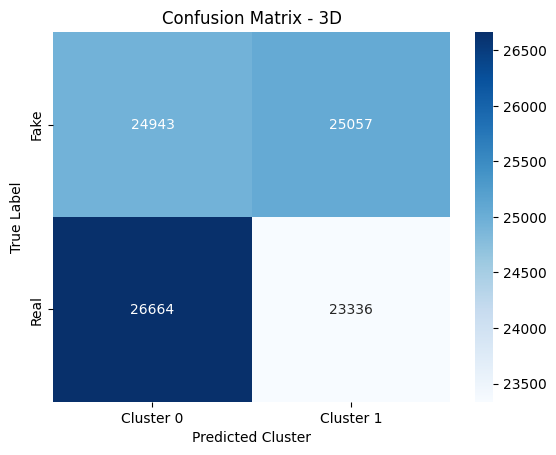

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the actual labels for fake and real images
actual_labels = [0] * len(train_fake) + [1] * len(train_real)

# Create a confusion matrix
conf_matrix = confusion_matrix(actual_labels, clusters)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.title('Confusion Matrix - 3D')
plt.show()

<i>With the understanding that HOG features provide a foundational but incomplete picture, we naturally progress to exploring more advanced methods. The next phase of our research will delve into <b>Logistic regression</b>, which promise a deeper and more detailed analysis for our classification task.</i>

<a class="anchor" id="LR"></a>

<b>Logistic regression</b>

<i>Lets see what Logistic regression will discover with the HOGs data.</i>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Combine fake and real HOG features
all_hogs_data = train_fake_hog + train_real_hog

# Create labels (0 for fake, 1 for real)
labels = [0] * len(train_fake_hog) + [1] * len(train_real_hog)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_hogs_data, labels, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build Logistic Regression model
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred = logistic_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)


Accuracy: 0.71
Confusion Matrix:
[[6981 3054]
 [2758 7207]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71     10035
           1       0.70      0.72      0.71      9965

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000



C:\Users\Yehiam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<b>Confusion matrix</b>

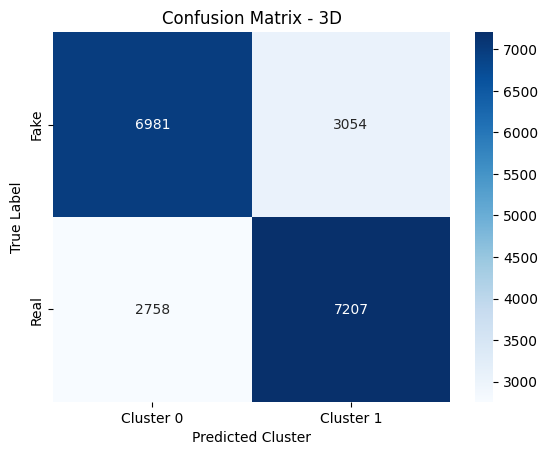

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.title('Confusion Matrix - 3D')
plt.show()

<b>Logistic regression base HOGs data conclusion</b>

The logistic regression model achieved a commendable accuracy of 71%, successfully discerning between real and fake images. The confusion matrix illustrates 6981 true negatives and 7207 true positives, showcasing the model's effectiveness. Precision and recall metrics are well-balanced, resulting in an F1-score of 71%. While logistic regression proves valuable, deeper insights into image classification may be gained by exploring more complex models.

<i>Let's delve further and consider the potential of Convolutional Neural Networks (CNNs) for a more nuanced and sophisticated approach to image analysis.</i>

________________________________________________________________________________________________________________________

<a class="anchor" id="CNN"></a>

<h1><b>Convolutional Neural Network (CNN)</b></h1>

<b>Introduction to CNN</b>

After exploring a few analytical tools and delving deep into our dataset, we are now ready to embark on the development of a Convolutional Neural Network (CNN). This network will be strategically fed with the right variables and undergo ideal data augmentation, including adjustments in brightness levels, zoom, and more. Our approach will also involve making well-informed decisions about the network's structure, such as determining the optimal number of layers.

<a class="anchor" id="bnm"></a>

<h2><b><u>basic CNN model</u></b></h2>

The architecture of our CNN is thoughtfully designed with a series of layers, each serving a distinct purpose:

* Convolutional Layers: Fundamental for feature extraction, these layers use learned filters to identify important features in the images.

* Pooling Layers: These layers perform down-sampling to reduce the size of the feature maps, decreasing computational requirements and helping prevent overfitting.

* Normalization Layers: Essential for training stability, they normalize the inputs within each mini-batch.

* Fully Connected Layers: Positioned towards the end, they interpret the extracted features and carry out the classification task.

* Dropout Layer: This layer aids in regularization, randomly disabling neurons during training to reduce overfitting.

* Output Layer with Sigmoid Activation: Employing a sigmoid activation function, this layer is tailored for binary classification, producing a probability score indicative of class membership.

<b>import data</b>

In [19]:
training_data = tf.keras.utils.image_dataset_from_directory(
    'cifake-real-and-ai-generated-synthetic-images\\train',
    image_size=(32, 32))


Found 100000 files belonging to 2 classes.


In [20]:
training_data.class_names

['FAKE', 'REAL']

<b>Normalization</b>

In [21]:
normalized_training_data = training_data.map(lambda x, y : (x/255, y))


In [22]:
print(normalized_training_data)
print("number of training batches: ", len(normalized_training_data))

<_MapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
number of training batches:  3125


In [23]:
# Split the dataset
train_size = int(len(normalized_training_data) * 0.8)
validation_size = int(len(normalized_training_data) * 0.2)


train = normalized_training_data.take(train_size)
validation = normalized_training_data.skip(train_size).take(validation_size)

print("train size: ", train_size)
print("validation size: ", validation_size)


train size:  2500
validation size:  625


<b>CNN creation</b>

In [24]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPooling2D((2, 2)))

cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPooling2D((2, 2)))

cnn.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn.add(tf.keras.layers.BatchNormalization())

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dropout(0.5))

cnn.add(tf.keras.layers.Dense(64, activation='relu'))
cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
# compile the model
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision()])


# Train the model
history = cnn.fit(train , validation_data=validation , epochs=10)

Epoch 1/10


2500/2500 [==============================] - 117s 46ms/step - loss: 0.3141 - accuracy: 0.8696 - precision_4: 0.8667 - val_loss: 0.2877 - val_accuracy: 0.8836 - val_precision_4: 0.9584
Epoch 2/10
2500/2500 [==============================] - 111s 44ms/step - loss: 0.2152 - accuracy: 0.9138 - precision_4: 0.9143 - val_loss: 0.2482 - val_accuracy: 0.9026 - val_precision_4: 0.9501
Epoch 3/10
2500/2500 [==============================] - 110s 44ms/step - loss: 0.1901 - accuracy: 0.9250 - precision_4: 0.9263 - val_loss: 0.2015 - val_accuracy: 0.9220 - val_precision_4: 0.9198
Epoch 4/10
2500/2500 [==============================] - 107s 43ms/step - loss: 0.1741 - accuracy: 0.9308 - precision_4: 0.9318 - val_loss: 0.5600 - val_accuracy: 0.7945 - val_precision_4: 0.9903
Epoch 5/10
2500/2500 [==============================] - 109s 44ms/step - loss: 0.1606 - accuracy: 0.9366 - precision_4: 0.9373 - val_loss: 0.1672 - val_accuracy: 0.9359 - val_precision_4: 0.9273
Epoch 6/10
2500/2500 [==============

In [ ]:
cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_26 (Ba  (None, 30, 30, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 batch_normalization_27 (Ba  (None, 13, 13, 64)        256       
 tchNormalization)                                               
                                                      

<b>measurments choise explaination</b>

When evaluating Convolutional Neural Networks (CNNs) in the context of image classification, it's crucial to select metrics that effectively capture the model's performance. We've chosen to measure our CNN models with accuracy and precision for several reasons:

* Accuracy: This straightforward metric indicates how often the model correctly classifies images, providing a clear measure of overall performance.

* Precision: Precision highlights the model's ability to correctly identify positive instances (like 'fake' images) while minimizing false positives, crucial in scenarios where trust is paramount.

* Balancing False Positives and True Positives: Precision offers insight into the model's effectiveness in critical classifications, ensuring that its performance isn't skewed by an imbalanced dataset.

* Relevance to the Task: Both metrics are vital for tasks like detecting fake images, where accuracy ensures general performance and precision addresses the importance of correctly identifying critical cases.

In conclusion, measuring our CNN models with both accuracy and precision provides a comprehensive view of their performance. It ensures that the models are not only effective in general image classification but are also reliable in identifying and classifying the most crucial cases, which is essential for maintaining credibility and trust in digital content.

<b>Epochs results</b>

In [ ]:
# Access accuracy and loss values from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']


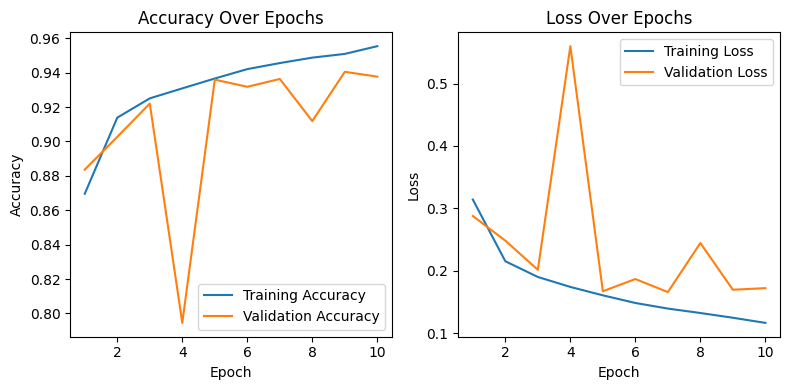

In [ ]:
import matplotlib.pyplot as plt

num_epochs = 10


# Create subplots for accuracy and loss
plt.figure(figsize=(8, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

# Display the plots
plt.tight_layout()
plt.show()

<b>Performance Summary of CNN Training Epochs</b>

Over the course of 10 training epochs, our CNN model has shown notable improvement and consistent performance. Key observations include:

1) Decreasing Loss: There is a clear trend of decreasing loss, both in training and validation, indicating that the model is learning effectively and becoming more accurate in its predictions.

2) Increasing Accuracy and Precision: Both accuracy and precision metrics have shown a steady increase. By the 10th epoch, the model achieved an accuracy of 95.54% and precision of 95.49% in training, which reflects its ability to correctly identify and classify images.

3) Validation Performance: The validation accuracy and precision also improved, reaching up to 93.77% and 91.10%, respectively, by the final epoch. This suggests that the model generalizes well to new, unseen data.

4) Observations on Overfitting: Despite some fluctuations, particularly in the 4th epoch where validation loss spiked, the model maintained a stable performance overall. This indicates good regularization practices, helping to avoid overfitting.


<b>--></b>In conclusion, the training process of our CNN model has been successful, demonstrating its capability to effectively distinguish between real and AI-generated images. The results from these epochs provide a strong foundation for deploying the model in practical applications.



<b>save & load the model </b>

In [ ]:
cnn.save('FAKE_REAL_IMG_cnn_model_V11.h5')

C:\Users\Yehiam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
model = tf.keras.models.load_model('FAKE_REAL_IMG_cnn_model_V11.h5')

<b>prediction example</b>

images in every class

In [26]:
# reading the XLSX file
FAKE_TEST_folder =('cifake-real-and-ai-generated-synthetic-images\\test\FAKE')
REAL_TEST_folder =('cifake-real-and-ai-generated-synthetic-images\\test\REAL')

fake_test_images_path = []
real_test_images_path = []

for fakefilename in os.listdir(FAKE_TEST_folder):
  fake_img = os.path.join(FAKE_TEST_folder,fakefilename)
  if fake_img is not None:
      fake_test_images_path.append(fake_img)

for realfilename in os.listdir(REAL_TEST_folder):
  real_img = os.path.join(REAL_TEST_folder,realfilename)
  if real_img is not None:
      real_test_images_path.append(real_img)


<b>Fake prediction</b>

1/1 [==============================] - 0s 51ms/step


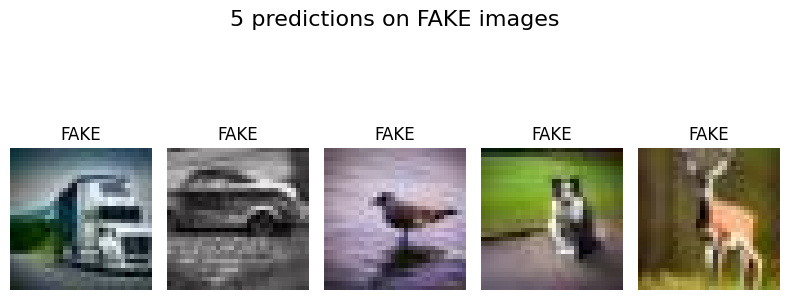

In [27]:
# Create a figure with 5 subplots side by side
fig, axes = plt.subplots(1,  5,figsize=(8, 4))
fig.suptitle("5 predictions on FAKE images", fontsize=16)

for i in range(5):
    image = cv2.imread(fake_test_images_path[i])

    test_image = tf.keras.utils.load_img(fake_test_images_path[i], target_size = (32, 32))
    test_image = tf.keras.utils.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    test_image /= 255.0
    result = model.predict(test_image)

    # Check if the image was loaded successfully
    if image is not None:
        # Displaying the image
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if result[0][0] > 0.5:
            axes[i].set_title('REAL')
        else:
            axes[i].set_title('FAKE')
    else:
        print(f"Error loading image {images_path[i]}")

# Remove axis labels and ticks
for ax in axes:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()


<b>Real prediction</b>

1/1 [==============================] - 0s 47ms/step


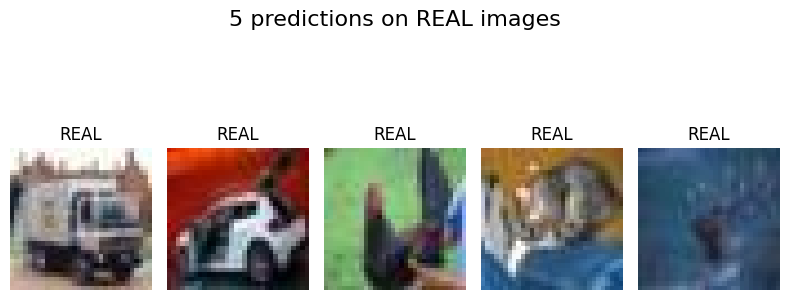

In [28]:
# Create a figure with 5 subplots side by side
fig, axes = plt.subplots(1, 5, figsize=(8, 4))
fig.suptitle("5 predictions on REAL images", fontsize=16)

for i in range(5):
    image = cv2.imread(real_test_images_path[i])

    test_image = tf.keras.utils.load_img(real_test_images_path[i], target_size = (32, 32))
    test_image = tf.keras.utils.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    test_image /= 255.0
    result = model.predict(test_image)

    # Check if the image was loaded successfully
    if image is not None:
        # Displaying the image
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if result[0][0] > 0.5:
            axes[i].set_title('REAL')
        else:
            axes[i].set_title('FAKE')
    else:
        print(f"Error loading image {images_path[i]}")

# Remove axis labels and ticks
for ax in axes:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()


<b>Test prediction result</b>

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import preprocess_input
from collections import Counter


# Define a function to make predictions on an image
def predict_image(image_path):
    prediction = 0
    test_image = tf.keras.utils.load_img(image_path, target_size = (32, 32))
    test_image = tf.keras.utils.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    test_image /= 255.0
    result = model.predict(test_image, verbose=0)

    if result[0][0] > 0.5:
        prediction = 1
    else:
        prediction = 0

    return prediction


In [ ]:
# Specify your test folder containing "FAKE" and "REAL" subfolders
test_folder = "cifake-real-and-ai-generated-synthetic-images\\test"

# Initialize variables to store prediction results
correct_predictions = 0
incorrect_predictions = 0
correct_real_predictions = 0
correct_fake_predictions = 0
incorrect_real_predictions = 0
incorrect_fake_predictions = 0

# Loop through the images in the test folder
for subfolder in os.listdir(test_folder):
    subfolder_path = os.path.join(test_folder, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_file)
        prediction = predict_image(image_path)
        # predicted_class = int(prediction[0][0])
        # Assuming that the class labels are 0 for "REAL" and 1 for "FAKE"

        if(subfolder == "FAKE"):
            if(prediction == 0):
                correct_predictions += 1
                correct_fake_predictions += 1
            else:
                incorrect_predictions += 1
                incorrect_fake_predictions += 1
        else:
            if(prediction == 1):
                correct_predictions += 1
                correct_real_predictions += 1
            else:
                incorrect_predictions += 1
                incorrect_real_predictions += 1

print("correct_real_predictions: ",correct_real_predictions,
    "\ncorrect_fake_predictions: ", correct_fake_predictions,
    "\nincorrect_real_predictions: ", incorrect_real_predictions,
    "\nincorrect_fake_predictions: ", incorrect_fake_predictions
    )

correct_real_predictions:  9734 
correct_fake_predictions:  8977 
incorrect_real_predictions:  266 
incorrect_fake_predictions:  1023


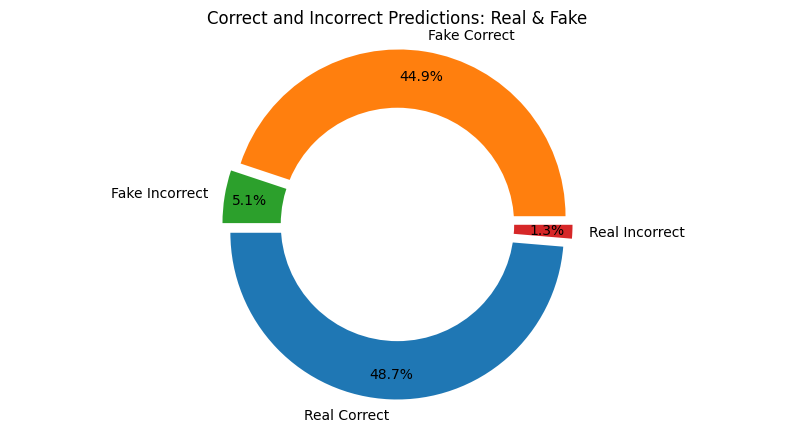

In [ ]:
import matplotlib.pyplot as plt

# Given results for correct predictions
labels = ['Real Correct',  'Real Incorrect','Fake Correct', 'Fake Incorrect']
sizes = [correct_real_predictions,  incorrect_real_predictions,correct_fake_predictions, incorrect_fake_predictions]  # Correct and incorrect predictions out of 10000
colors = ['#1f77b4',  '#d62728','#ff7f0e', '#2ca02c']  # Colors for each section
explode = (0.05, 0.05, 0.05, 0.05)  # Explode all slices

# Create a pie chart as a half-circle donut chart
plt.figure(figsize=(10, 5))
plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', pctdistance=0.85, explode=explode, startangle=180)

# Draw a circle at the center to turn the pie chart into a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Adjust the aspect ratio to ensure the pie is drawn as a half-circle
plt.axis('equal')

# Adding Title of chart
plt.title('Correct and Incorrect Predictions: Real & Fake')

# Displaying Chart
plt.show()


<b>confusion matrix</b>

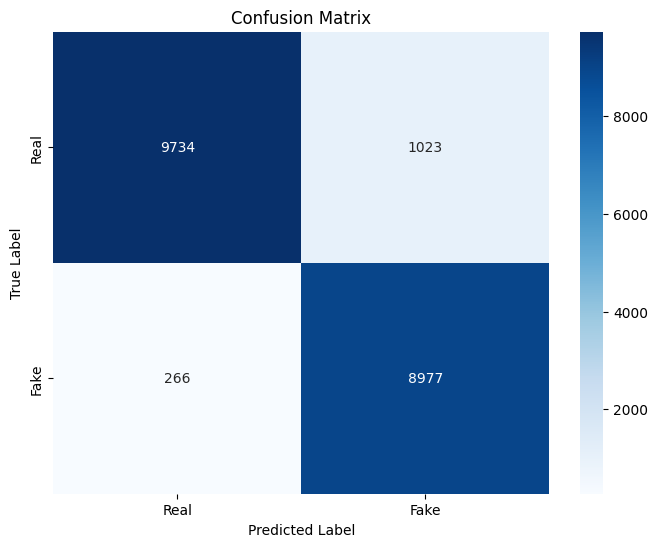

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Creating the confusion matrix
conf_matrix = [
    [correct_real_predictions, incorrect_fake_predictions],
    [incorrect_real_predictions, correct_fake_predictions]
]

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Having observed the outcomes of our basic Convolutional Neural Network (CNN) and its promising results, our journey in image classification now advances to exploring a more sophisticated model: ResNet50

<a class="anchor" id="resnet"></a>

<h2><b><u>ResNet model</u></b></h2>

<b>About ResNet50</b>

ResNet-50, an acronym for "Residual Network," presents a cutting-edge deep convolutional neural network architecture meticulously designed to combat the vanishing gradient problem pervasive in exceedingly deep networks. This model distinguishes itself through the ingenious incorporation of residual blocks, each equipped with shortcut connections. These connections empower the model to effortlessly grasp residual functions, thereby streamlining the training of exceptionally deep networks.

To enhance comprehension, refer to the illustration below:

<img src="https://wisdomml.in/wp-content/uploads/2023/03/resnet_bannner.png" alt="ResNet50 Architecture" width="500"/>

Our preference for ResNet50 stems from its compelling attributes in the realm of deep neural network architectures. Its distinctive design, featuring residual blocks and shortcut connections, directly addresses the vanishing gradient problem, ensuring the successful training of remarkably deep networks. Leveraging these residual connections facilitates the acquisition of residual functions, empowering the model to discern intricate patterns and features. ResNet-50 boasts outstanding performance across various computer vision tasks, including image classification and object detection, establishing it as a sought-after choice for transfer learning. The model's adept handling of deep architectures, complemented by pre-trained weights on extensive datasets, renders ResNet-50 a robust and versatile solution for tasks demanding feature-rich representations.









In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras import layers
from keras import models
from keras import optimizers

<b>ResNet creation</b>

In [ ]:
# Define the ResNet-50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [ ]:
# Create a new model and add custom top layers
ResNetmodel = models.Sequential()
ResNetmodel.add(base_model)
ResNetmodel.add(layers.GlobalAveragePooling2D())
#ResNetmodel.add(layers.Dense(256, activation='relu'))
ResNetmodel.add(layers.Dropout(0.5))
ResNetmodel.add(layers.Dense(1, activation='sigmoid'))


In [ ]:
# Freeze the layers of the ResNet model
#for layer in base_model.layers:
#    layer.trainable = False

# Compile the model
ResNetmodel.compile(optimizer="adam", loss='binary_crossentropy',  metrics=['accuracy',tf.keras.metrics.Precision()])

<b>Model training</b>

In [ ]:
# Train the model
history = ResNetmodel.fit(train, epochs=5, validation_data=validation)


Epoch 1/5


2500/2500 [==============================] - 2995s 1s/step - loss: 0.4273 - accuracy: 0.8438 - precision_12: 0.8432 - val_loss: 0.2813 - val_accuracy: 0.8860 - val_precision_12: 0.8395
Epoch 2/5
2500/2500 [==============================] - 3001s 1s/step - loss: 0.3503 - accuracy: 0.8725 - precision_12: 0.8787 - val_loss: 0.3231 - val_accuracy: 0.8651 - val_precision_12: 0.9469
Epoch 3/5
2500/2500 [==============================] - 2983s 1s/step - loss: 0.3031 - accuracy: 0.8793 - precision_12: 0.8945 - val_loss: 0.2605 - val_accuracy: 0.8978 - val_precision_12: 0.8792
Epoch 4/5
2500/2500 [==============================] - 3166s 1s/step - loss: 0.2490 - accuracy: 0.9048 - precision_12: 0.9083 - val_loss: 1397.9645 - val_accuracy: 0.5270 - val_precision_12: 0.5162
Epoch 5/5
2500/2500 [==============================] - 2987s 1s/step - loss: 0.2799 - accuracy: 0.8957 - precision_12: 0.8997 - val_loss: 0.2389 - val_accuracy: 0.9047 - val_precision_12: 0.8645


In [ ]:
ResNetmodel.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_11 (Dropout)        (None, 2048)              0         
                                                                 
 dense_26 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 23536641 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
# Access accuracy and loss values from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

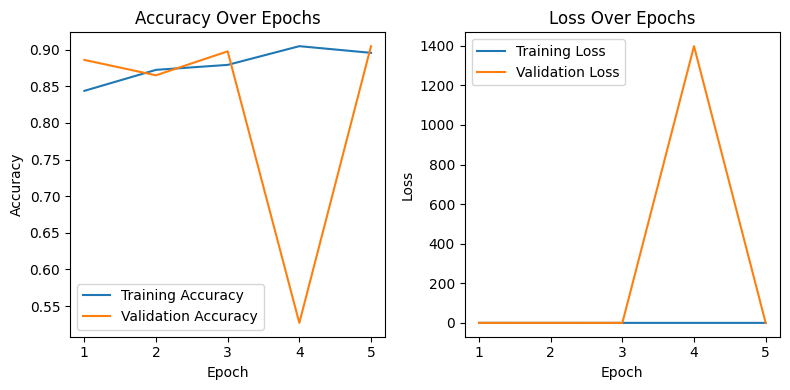

In [ ]:
import matplotlib.pyplot as plt

num_epochs = 5


# Create subplots for accuracy and loss
plt.figure(figsize=(8, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

# Display the plots
plt.tight_layout()
plt.show()

<b>save & load the model </b>

In [ ]:
ResNetmodel.save('FAKE_REAL_IMG_ResNet_model_V4.h5')

C:\Users\Yehiam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
model = tf.keras.models.load_model('FAKE_REAL_IMG_ResNet_model_V4.h5')

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import preprocess_input
from collections import Counter


# Define a function to make predictions on an image
def predict_image(image_path):
    prediction = 0
    test_image = tf.keras.utils.load_img(image_path, target_size = (32, 32))
    test_image = tf.keras.utils.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    test_image /= 255.0
    result = model.predict(test_image, verbose=0)

    if result[0][0] > 0.5:
        prediction = 1
    else:
        prediction = 0

    return prediction


In [ ]:
# Specify your test folder containing "FAKE" and "REAL" subfolders
test_folder = "cifake-real-and-ai-generated-synthetic-images\\test"

# Initialize variables to store prediction results
correct_predictions = 0
incorrect_predictions = 0
correct_real_predictions = 0
correct_fake_predictions = 0
incorrect_real_predictions = 0
incorrect_fake_predictions = 0

# Loop through the images in the test folder
for subfolder in os.listdir(test_folder):
    subfolder_path = os.path.join(test_folder, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_file)
        prediction = predict_image(image_path)
        # predicted_class = int(prediction[0][0])
        # Assuming that the class labels are 0 for "REAL" and 1 for "FAKE"

        if(subfolder == "FAKE"):
            if(prediction == 0):
                correct_predictions += 1
                correct_fake_predictions += 1
            else:
                incorrect_predictions += 1
                incorrect_fake_predictions += 1
        else:
            if(prediction == 1):
                correct_predictions += 1
                correct_real_predictions += 1
            else:
                incorrect_predictions += 1
                incorrect_real_predictions += 1

print("correct_real_predictions: ",correct_real_predictions,
    "\ncorrect_fake_predictions: ", correct_fake_predictions,
    "\nincorrect_real_predictions: ", incorrect_real_predictions,
    "\nincorrect_fake_predictions: ", incorrect_fake_predictions
    )

correct_real_predictions:  9646 
correct_fake_predictions:  8454 
incorrect_real_predictions:  354 
incorrect_fake_predictions:  1546


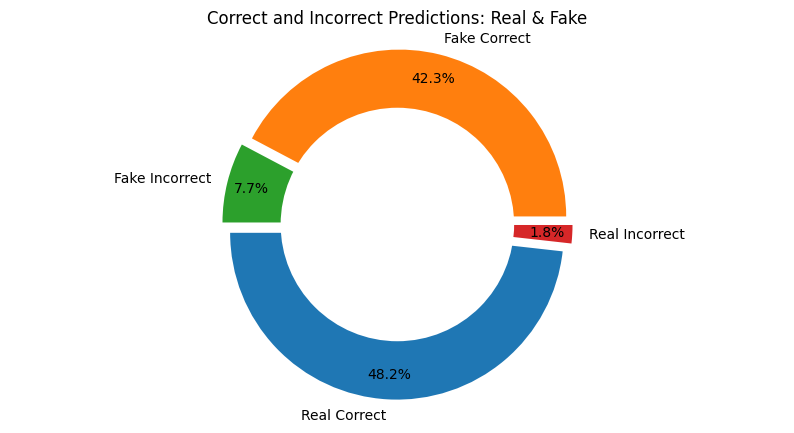

In [ ]:
import matplotlib.pyplot as plt

# Given results for correct predictions
labels = ['Real Correct',  'Real Incorrect','Fake Correct', 'Fake Incorrect']
sizes = [correct_real_predictions,  incorrect_real_predictions,correct_fake_predictions, incorrect_fake_predictions]  # Correct and incorrect predictions out of 10000

colors = ['#1f77b4',  '#d62728','#ff7f0e', '#2ca02c']  # Colors for each section
explode = (0.05, 0.05, 0.05, 0.05)  # Explode all slices

# Create a pie chart as a half-circle donut chart
plt.figure(figsize=(10, 5))
plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', pctdistance=0.85, explode=explode, startangle=180)

# Draw a circle at the center to turn the pie chart into a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Adjust the aspect ratio to ensure the pie is drawn as a half-circle
plt.axis('equal')

# Adding Title of chart
plt.title('Correct and Incorrect Predictions: Real & Fake')

# Displaying Chart
plt.show()


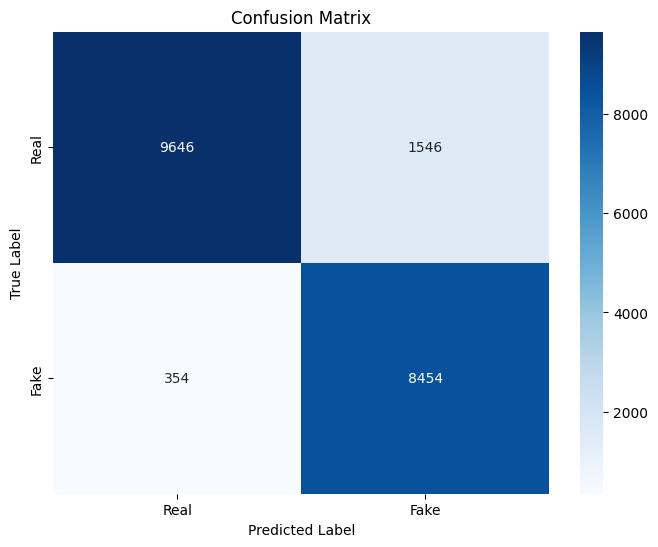

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Creating the confusion matrix
conf_matrix = [
    [correct_real_predictions, incorrect_fake_predictions],
    [incorrect_real_predictions, correct_fake_predictions]
]

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

<b>ResNet model summary</b>

In conclusion, the ResNet50 model, with its extensive parameter count and deep architecture, has shown a robust ability to learn and improve over training epochs. While facing challenges like a sudden spike in validation loss, it managed to recover and conclude with respectable accuracy and precision. This performance, combined with its comprehensive architectural design, makes it a formidable tool in the task of distinguishing between real and AI-generated images. Further fine-tuning and adjustments may be required to optimize its performance and stability further.

<a class="anchor" id="MC"></a>

<h1><b>Models comparison</b></h1>

Throughout this research, we've employed a series of analyses, each providing unique insights into the differentiation of real and AI-generated images. Our journey began with an Exploratory Data Analysis (EDA), where we identified key disparities in the number of colors and sharpness between the two types of images. Additionally, we performed Clustering Images using the K-Means Algorithm on the EDA, which, while yielding less favorable results, still contributed valuable insights that aided our subsequent analyses.

Utilizing the Vision Transformer (ViT) model and Support Vector Machine (SVM) for image classification, we achieved a notable 71.7% accuracy, showcasing the effectiveness of this combined approach. While these results are promising, ongoing efforts are directed towards refining the model and exploring additional features to further enhance performance. Our commitment to advancing image classification remains unwavering, as we seek continuous improvement in discriminating between real and AI-generated images.

We furthered our analysis through 2D and 3D examinations, seeking to discern patterns and distributions that could aid in our classification task. Despite a lack of significant differences in distribution within the 2D context, this groundwork was essential for our move into more complex three-dimensional analyses.

Implementing Histogram of Oriented Gradients (HOG) and logistic regression gave us almost identical accuracy as the Vision Transformer (ViT) model and Support Vector Machine (SVM), motivating ongoing exploration to optimize and advance our image classification research for enhanced outcomes.

Our focus then shifted to implementing and training a Convolutional Neural Network (CNN). Over 10 training epochs, the CNN demonstrated substantial improvements in accuracy, precision, and loss reduction. This progression not only showcased the model's learning capabilities but also its potential in generalizing to new data effectively.

Concluding our explorations, we incorporated the ResNet-50 model, attaining favorable results that, while slightly lower than those obtained with the custom CNN we developed, still showcase the effectiveness of our varied methodologies. This comparative analysis underscores the versatility of our approach in image classification.

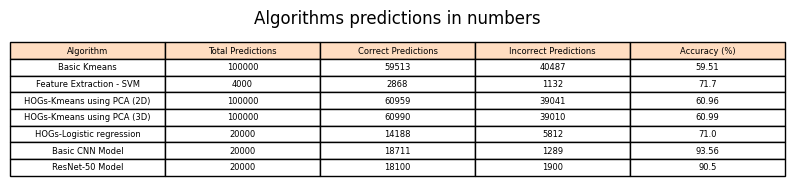

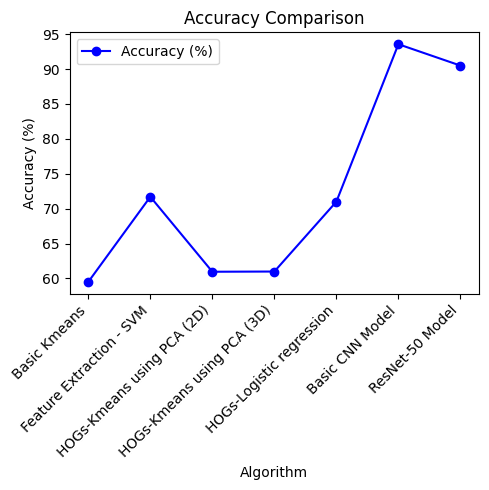

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Confusion matrices data
data = {
    'Algorithm': ['Basic Kmeans', 'Feature Extraction - SVM','HOGs-Kmeans using PCA (2D)', 'HOGs-Kmeans using PCA (3D)','HOGs-Logistic regression', 'Basic CNN Model', 'ResNet-50 Model'],
    'Total Predictions': [100000, 4000,100000, 100000, 20000 , 20000, 20000],
    'Correct Predictions': [59513, 2868,60959, 60990,14188, 18711, 18100],
    'Incorrect Predictions': [40487, 1132,39041, 39010,5812, 1289, 1900],
    'Accuracy (%)': [59.51,71.70, 60.96, 60.99,71.0 ,93.56, 90.5]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Separate the 'Accuracy (%)' column
accuracy_data = df[['Algorithm', 'Accuracy (%)']]

# Plotting the comparison table
fig, ax = plt.subplots(figsize=(10, 2))
ax.set_title('Algorithms predictions in numbers')
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', colColours=['#FFDDC1']*df.shape[1])

# Plotting the line graph for Accuracy (%)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(accuracy_data['Algorithm'], accuracy_data['Accuracy (%)'], marker='o', color='b', label='Accuracy (%)')
ax.set_title('Accuracy Comparison')
ax.set_xlabel('Algorithm')
ax.set_ylabel('Accuracy (%)')
ax.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


<a class="anchor" id="REC"></a>

<h1><b>Research Conclusion</b></h1>

Our research took us from theory to practice, leading to the creation of a CNN model ready for real-world testing. This journey emphasized the importance of thorough analysis and strong modeling techniques in the complex task of distinguishing real from AI-generated images.

All explored algorithms surpassed a basic 50/50 guess, showing the effectiveness of our approach. From Basic Kmeans and Feature Extraction with SVM to HOGs-Kmeans, HOGs-Logistic Regression, and the advanced Basic CNN and ResNet-50 models, each algorithm contributed to our understanding of image classification.

The CNN model stood out as the best performer, highlighting the effectiveness of its layered structure and training process. Our success goes beyond accuracy, consistently exceeding our expectations.

These algorithms, along with our developed CNN model, represent a significant step forward in image classification. The journey was filled with excitement, resilience, and validation through tangible results. As we move to real-world testing, we carry gained knowledge, conquered challenges, and the confidence that our efforts in image authenticity verification are not just promising but transformative.

__________________________________________________________________________

<h1><b>bonus: Frequency Domain</h1>

<b>Why Frequency Domain Analysis is Useful:</b>

1. Reveals Hidden Patterns: Some manipulations or characteristics might not be visible in the spatial domain but become evident when you look at the frequency components.

2. Focus on Textures and Edges: Frequency domain analysis can help highlight repetitive textures or unnatural edges that might indicate an image has been altered or generated.

3. Robustness to Color and Brightness Variations: Frequency analysis can be less sensitive to changes in lighting or color, focusing instead on structural information.

<b>create the frequency domain dataset by calculate FFT of every image

In [ ]:
import os
import cv2
import numpy as np

# Define input and output directories
input_dir = "cifake-real-and-ai-generated-synthetic-images"
output_dir = "freq-real-fake-images"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)


categories = ["test", "train"]

# Loop through each category
for category in categories:
    category_dir = os.path.join(input_dir, category)
    output_category_dir = os.path.join(output_dir, category)
    os.makedirs(output_category_dir, exist_ok=True)

    # List of subdirectories (e.g., "train" and "test")
    subdirectories = ["FAKE", "REAL"]

    # Loop through each subdirectory
    for subdirectory in subdirectories:
        view_flag = 1
        input_subdir = os.path.join(category_dir, subdirectory)
        output_subdir = os.path.join(output_category_dir, subdirectory)
        os.makedirs(output_subdir, exist_ok=True)

        # Process each image in the subdirectory
        for filename in os.listdir(input_subdir):
            input_path = os.path.join(input_subdir, filename)
            output_path = os.path.join(output_subdir, filename)

            # Read the image
            image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

            # Perform FFT (Fast Fourier Transform) to calculate the frequency domain
            freq_domain = np.fft.fft2(image)
            freq_domain = np.fft.fftshift(freq_domain)

            # Save the frequency domain image
            cv2.imwrite(output_path, np.abs(freq_domain).astype(np.uint8))



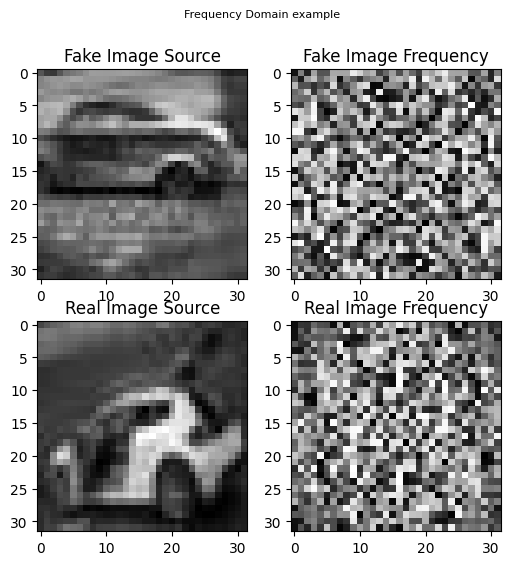

In [ ]:
import cv2

# Plot information
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
fig.suptitle("Frequency Domain example", fontsize=8)

fake_spatial_image = cv2.imread(r"cifake-real-and-ai-generated-synthetic-images\\test\FAKE\\0 (2).jpg", cv2.IMREAD_GRAYSCALE)
fake_frequency_image = cv2.imread(r"freq-real-fake-images\\test\FAKE\\0 (2).jpg", cv2.IMREAD_GRAYSCALE)
real_spatial_image = cv2.imread(r"cifake-real-and-ai-generated-synthetic-images\\test\REAL\\0000 (2).jpg", cv2.IMREAD_GRAYSCALE)
real_frequency_image = cv2.imread(r"freq-real-fake-images\\test\REAL\\0000 (2).jpg", cv2.IMREAD_GRAYSCALE)

axes[0, 0].imshow(fake_spatial_image, cmap=plt.cm.gray)
axes[0, 0].set_title("Fake Image Source")
axes[0, 1].imshow(fake_frequency_image, cmap=plt.cm.gray)
axes[0, 1].set_title("Fake Image Frequency")
axes[1, 0].imshow(real_spatial_image, cmap=plt.cm.gray)
axes[1, 0].set_title("Real Image Source")
axes[1, 1].imshow(real_frequency_image, cmap=plt.cm.gray)
axes[1, 1].set_title("Real Image Frequency")
plt.show()

<b>compute the relevant values</b>

In [ ]:
import os
import cv2
import numpy as np
from scipy.stats import skew, kurtosis

def compute_statistics(image):
    # Flatten the image to 1D for statistical analysis
    pixels = image.flatten()

    # Calculate statistical metrics
    mean = np.mean(pixels)
    variance = np.var(pixels)
    skewness = skew(pixels)
    kurt = kurtosis(pixels)

    return mean, variance, skewness, kurt

In [ ]:

# Define the directory containing the frequency domain images
input_dir = "freq-real-fake-images\\train"

subdirectories = ["FAKE", "REAL"]

# Store the statistics for each image
FAKE_stats = []
REAL_stats = []

# Loop through each category and subdirectory
for subdirectory in subdirectories:
    subdir_path = os.path.join(input_dir, subdirectory)
    # Process each image in the subdirectory
    for filename in os.listdir(subdir_path):
        file_path = os.path.join(subdir_path, filename)

        # Read the image
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        # Compute statistics for the image
        image_stats = compute_statistics(image)

        # Append the statistics with a label indicating real or fake
        if subdirectory == "FAKE":
            FAKE_stats.append(image_stats)
        else:
            REAL_stats.append(image_stats)

# Convert the stats to a NumPy array for easier manipulation and analysis
FAKE_stats_array = np.array(FAKE_stats, dtype=object)
REAL_stats_array = np.array(REAL_stats, dtype=object)


In [ ]:
print(FAKE_stats[:5])
print(REAL_stats[:5])

[[(126.6123046875, 4808.5244970321655, 0.02106805456722879, -1.0007836605888134)], [(126.939453125, 5323.892818450928, 0.01487860900899113, -1.2038938237571684)], [(125.0615234375, 5473.442503929138, 0.034526557914706456, -1.2343404607036164)], [(122.8701171875, 5060.085669517517, 0.10931060825103289, -1.0625085214746397)], [(125.162109375, 5219.102626800537, -0.039356271807930464, -1.1261784849344174)]]
[[(125.099609375, 5154.464687347412, 0.08154052117984582, -1.1670095317125666)], [(125.3037109375, 4815.982954978943, 0.09446852863528588, -1.132242186840471)], [(118.4921875, 5343.019470214844, 0.21832447882028047, -1.1146685979301765)], [(113.2158203125, 4872.054007530212, 0.3120438211839119, -1.0576994974029337)], [(120.501953125, 5211.261714935303, 0.144333882911972, -1.1888816861986513)]]


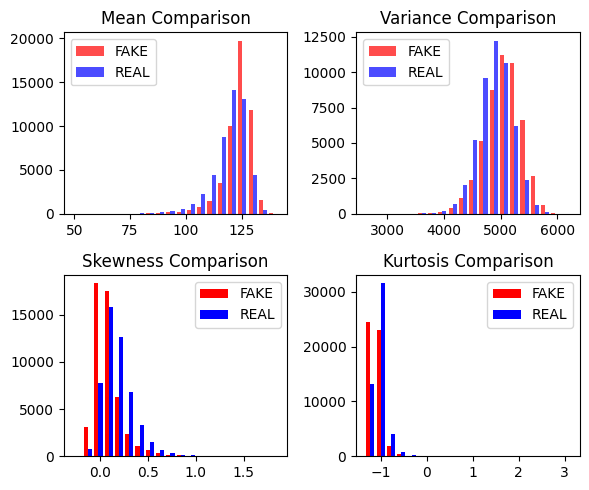

In [ ]:
import matplotlib.pyplot as plt

# Convert the statistics lists to numpy arrays for easier manipulation
FAKE_stats_np = np.array(FAKE_stats)
REAL_stats_np = np.array(REAL_stats)

# Extract individual statistics for plotting
mean_FAKE = FAKE_stats_np[:, 0, 0]
variance_FAKE = FAKE_stats_np[:, 0, 1]
skewness_FAKE = FAKE_stats_np[:, 0, 2]
kurt_FAKE = FAKE_stats_np[:, 0, 3]

mean_REAL = REAL_stats_np[:, 0, 0]
variance_REAL = REAL_stats_np[:, 0, 1]
skewness_REAL = REAL_stats_np[:, 0, 2]
kurt_REAL = REAL_stats_np[:, 0, 3]

# Create subplots for each statistical metric
fig, axs = plt.subplots(2, 2, figsize=(6, 5))

# Mean comparison
axs[0, 0].hist([mean_FAKE, mean_REAL], bins=20, color=['red', 'blue'], alpha=0.7, label=['FAKE', 'REAL'])
axs[0, 0].set_title('Mean Comparison')
axs[0, 0].legend()

# Variance comparison
axs[0, 1].hist([variance_FAKE, variance_REAL], bins=20, color=['red', 'blue'], alpha=0.7, label=['FAKE', 'REAL'])
axs[0, 1].set_title('Variance Comparison')
axs[0, 1].legend()

# Skewness comparison
axs[1, 0].hist([skewness_FAKE, skewness_REAL], bins=20, color=['red', 'blue'], label=['FAKE', 'REAL'])
axs[1, 0].set_title('Skewness Comparison')
axs[1, 0].legend()

# Kurtosis comparison
axs[1, 1].hist([kurt_FAKE, kurt_REAL], bins=20, color=['red', 'blue'], label=['FAKE', 'REAL'])
axs[1, 1].set_title('Kurtosis Comparison')
axs[1, 1].legend()

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


In [ ]:
# Extracting the first two values from each subarray
relevant_FAKE_stats = [sub[0][2:4] for sub in FAKE_stats]
relevant_REAL_stats = [sub[0][2:4] for sub in REAL_stats]
print(relevant_FAKE_stats[:5])
print(relevant_REAL_stats[:5])

[(0.02106805456722879, -1.0007836605888134), (0.01487860900899113, -1.2038938237571684), (0.034526557914706456, -1.2343404607036164), (0.10931060825103289, -1.0625085214746397), (-0.039356271807930464, -1.1261784849344174)]
[(0.08154052117984582, -1.1670095317125666), (0.09446852863528588, -1.132242186840471), (0.21832447882028047, -1.1146685979301765), (0.3120438211839119, -1.0576994974029337), (0.144333882911972, -1.1888816861986513)]


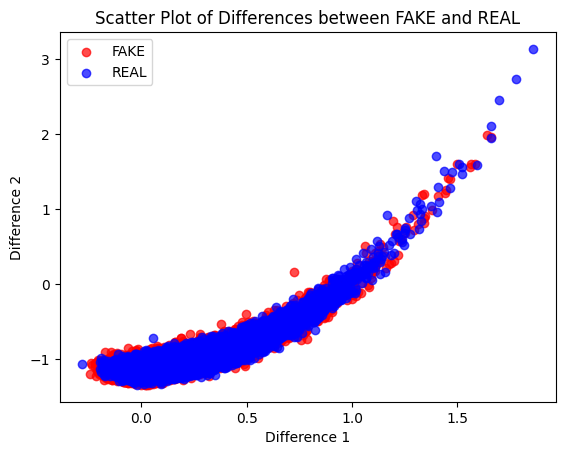

In [ ]:
# Extract x and y values
x_FAKE, y_FAKE = zip(*relevant_FAKE_stats)
x_REAL, y_REAL = zip(*relevant_REAL_stats)

# Create scatter plot
plt.scatter(x_FAKE, y_FAKE, c='red', label='FAKE', alpha=0.7)
plt.scatter(x_REAL, y_REAL, c='blue', label='REAL', alpha=0.7)

# Set plot labels and title
plt.xlabel('Difference 1')
plt.ylabel('Difference 2')
plt.title('Scatter Plot of Differences between FAKE and REAL')

# Add legend
plt.legend()

# Show the plot
plt.show()